In [22]:
# Imports ready 
import os
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75

BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'


In [23]:
# PATH CONFIGURATION - ready
# ============================================================
BASE_DIR = r"C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data"

# Test_Susceptible paths
SUSCEPTIBLE_REF_DIR = os.path.join(BASE_DIR, "Test_Susceptible", "REF_masks111_131_for_testing")
SUSCEPTIBLE_TREAT_DIR = os.path.join(BASE_DIR, "Test_Susceptible", "RIF10_masks211_217_for_testing")

# Test_HR paths
HR_REF_DIR = os.path.join(BASE_DIR, "Test_HR", "REF_masks")
HR_TREAT_DIR = os.path.join(BASE_DIR, "Test_HR", "TREAT_masks")

print(f"Base directory: {BASE_DIR}")
print(f"Susceptible REF: {SUSCEPTIBLE_REF_DIR}")
print(f"Susceptible TREAT: {SUSCEPTIBLE_TREAT_DIR}")
print(f"HR REF: {HR_REF_DIR}")
print(f"HR TREAT: {HR_TREAT_DIR}")

Base directory: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data
Susceptible REF: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data\Test_Susceptible\REF_masks111_131_for_testing
Susceptible TREAT: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data\Test_Susceptible\RIF10_masks211_217_for_testing
HR REF: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data\Test_HR\REF_masks
HR TREAT: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data\Test_HR\TREAT_masks


In [24]:
# MULTI-POSITION LOADING ready
# ============================================================

image_format = "tif"
all_files = [] # This will hold files from ALL positions

# 1. Get a list of all items in the main directory
# We look specifically in SUSCEPTIBLE_REF_DIR based on your config
items = os.listdir(SUSCEPTIBLE_REF_DIR)

# 2. Filter for folders that look like position folders (e.g., "Pos111", "Pos112")
position_folders = [item for item in items if item.startswith("Pos") and os.path.isdir(os.path.join(SUSCEPTIBLE_REF_DIR, item))]
position_folders.sort() # Sort to keep order 111, 112, etc.

print(f"Found {len(position_folders)} position folders: {position_folders}")

# 3. Loop through each position folder
for pos_folder in position_folders:
    # Construct the path to the masks for this specific position
    # Assumes structure: .../PosXXX/PreprocessedPhaseMasks/
    current_input_dir = os.path.join(SUSCEPTIBLE_REF_DIR, pos_folder, "PreprocessedPhaseMasks")
    
    # Check if the PreprocessedPhaseMasks folder actually exists
    if not os.path.exists(current_input_dir):
        print(f"Warning: {current_input_dir} does not exist. Skipping.")
        continue

    # 4. Walk through the directory and gather files
    for r, d, f in os.walk(current_input_dir):
        for fil in f:
            if image_format:
                if fil.endswith(image_format):
                    all_files.append(os.path.join(r, fil))
            else:
                all_files.append(os.path.join(r, fil))
        break # only read the root of the PreprocessedPhaseMasks folder

# Update the main 'files' variable to contain everything we found
files = all_files

if len(files) == 0:
    print(f"Total number of images loaded: {len(files)}.")
    print("Cannot read image files. Check if folders have images.")
else:
    print(f"Successfully loaded {len(files)} images from {len(position_folders)} positions.")

Found 20 position folders: ['Pos111', 'Pos112', 'Pos113', 'Pos114', 'Pos115', 'Pos116', 'Pos117', 'Pos118', 'Pos119', 'Pos120', 'Pos121', 'Pos122', 'Pos123', 'Pos124', 'Pos125', 'Pos126', 'Pos127', 'Pos128', 'Pos129', 'Pos130']
Successfully loaded 2434 images from 20 positions.


Attempting to load 20 different positions...
Successfully loaded 20 positions.
Lengths vary from 121 to 121.
Trimming all data to 121 frames to allow stacking.
Saved stacked data to: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data\Test_Susceptible\REF_masks111_131_for_testing\stacked_merged_areas_growth_data.pickle
Final Data Shape: (20, 121)


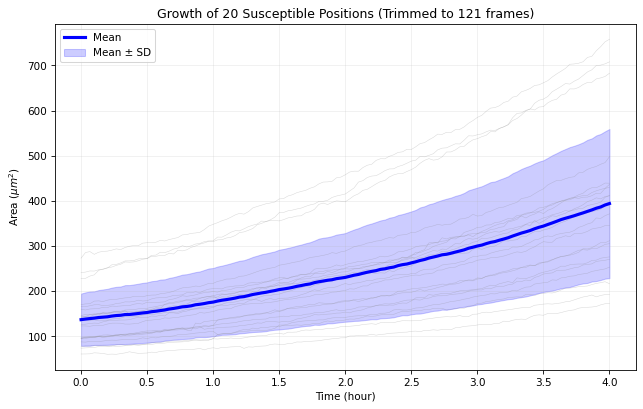

In [25]:
# 1. SETUP: Define the 20 DIFFERENT positions ready
# ==========================================
main_dir = SUSCEPTIBLE_REF_DIR
all_positions = list(range(111, 131))  # Pos111 to Pos130
empty_positions = []
positions = [pos for pos in all_positions if pos not in empty_positions]

list_position_dirs = []
for position in positions:
    # Construct folder name (e.g., Pos111)
    dir_string = f'Pos{position:03d}' # ensures 3 digits like Pos099 if needed
    directory = os.path.join(main_dir, dir_string)
    list_position_dirs.append(directory)

phase_dir_name = 'PreprocessedPhaseMasks'

# ==========================================
# 2. LOAD DATA
# ==========================================
merged_areas_growth_data = []
merged_growth_rate_data = []

print(f"Attempting to load {len(list_position_dirs)} different positions...")

for position_directory in list_position_dirs:
    # Check if folder exists
    if not os.path.exists(position_directory):
        print(f"Skipping missing directory: {position_directory}")
        continue
        
    folder_list = os.listdir(position_directory)
    
    for folder_name in folder_list:
        if folder_name == phase_dir_name:
            input_dir = os.path.join(position_directory, folder_name)
            
            # Check if mask folder is empty or missing
            if not os.path.exists(input_dir): 
                continue

            file_list = os.listdir(input_dir)
            
            for file_name in file_list:
                if file_name.endswith('growth_areas.pickle'):
                    with open(os.path.join(input_dir, file_name), 'rb') as f:
                        merged_areas_growth_data.append(pickle.load(f))

                if file_name.endswith('growth_rate.pickle'):
                    with open(os.path.join(input_dir, file_name), 'rb') as f:
                        merged_growth_rate_data.append(pickle.load(f))

# ==========================================
# 3. TRIM & STACK (The Fix)
# ==========================================
if len(merged_areas_growth_data) > 0:
    # Find the shortest length (e.g., 89 frames)
    lengths = [len(arr) for arr in merged_areas_growth_data]
    min_length = min(lengths)
    
    print(f"Successfully loaded {len(merged_areas_growth_data)} positions.")
    print(f"Lengths vary from {min(lengths)} to {max(lengths)}.")
    print(f"Trimming all data to {min_length} frames to allow stacking.")

    # Trim every array to the minimum length
    trimmed_areas = [arr[:min_length] for arr in merged_areas_growth_data]
    
    # Stack them
    stacked_merged_areas_growth_data = np.vstack(trimmed_areas)
    
    # Save the result
    output_path = os.path.join(main_dir, "stacked_merged_areas_growth_data.pickle")
    with open(output_path, "wb") as file:
        pickle.dump(stacked_merged_areas_growth_data, file)
        
    print(f"Saved stacked data to: {output_path}")
    print(f"Final Data Shape: {stacked_merged_areas_growth_data.shape}")

    # ==========================================
    # 4. PLOT (Optional Visualization)
    # ==========================================
    # Calculate stats
    areas_column_means = np.mean(stacked_merged_areas_growth_data, axis=0)
    areas_column_std_dev = np.std(stacked_merged_areas_growth_data, axis=0, ddof=1)
    areas_column_std_err = stats.sem(stacked_merged_areas_growth_data, axis=0, ddof=1)

    # Plotting variables
    num_pos, num_frame = stacked_merged_areas_growth_data.shape
    time_plot = [time*(2/60) for time in range(num_frame)]
    
    # Conversions
    pixel_scale = 0.0733**2
    corrected_areas_plot = stacked_merged_areas_growth_data * pixel_scale
    mean_plot = areas_column_means * pixel_scale
    std_plot = areas_column_std_dev * pixel_scale
    sem_plot = areas_column_std_err * pixel_scale

    plt.figure(facecolor='white', figsize=(10, 6))
    plt.plot(time_plot, corrected_areas_plot.T, lw=0.5, alpha=0.3, color='gray')
    plt.plot(time_plot, mean_plot, lw=3, color='blue', label='Mean')
    plt.fill_between(time_plot, mean_plot - std_plot, mean_plot + std_plot, 
                     color='blue', alpha=0.2, label='Mean ± SD')
    
    plt.xlabel('Time (hour)')
    plt.ylabel(r'Area ($\mu m^2$)')
    plt.title(f'Growth of {num_pos} Susceptible Positions (Trimmed to {min_length} frames)')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

else:
    print("Error: No growth_areas.pickle files found in any position folder.")

Attempting to load 7 Treated positions...
Successfully loaded 7 positions.
Lengths vary from 121 to 121.
Trimming all data to 121 frames to allow stacking.
Saved stacked data to: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\Test_Data\Test_Susceptible\RIF10_masks211_217_for_testing\stacked_merged_areas_growth_data.pickle
Final Data Shape: (7, 121)


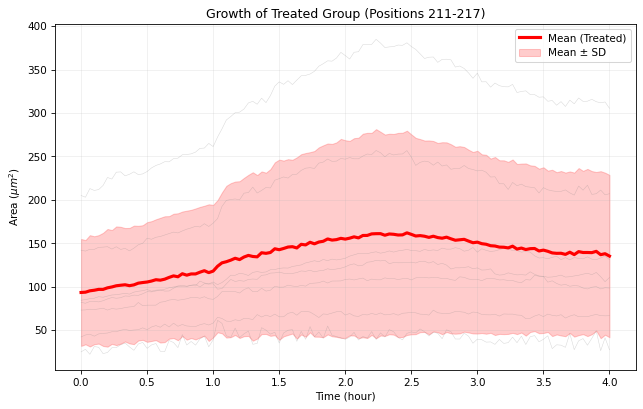

In [26]:
# 1. SETUP: Define Treated Positions (Pos211-217) ready 
# ==========================================
# Update to Test_Susceptible (Treated) data path
main_dir = SUSCEPTIBLE_TREAT_DIR 
all_positions = list(range(211, 218))  # Pos211 to Pos217
empty_positions = []
positions = [pos for pos in all_positions if pos not in empty_positions]

list_position_dirs = []
for position in positions:
    if position < 100:
        dir_string = 'Pos0' + str(position)
    else:
        dir_string = 'Pos' + str(position)
    
    directory = os.path.join(main_dir, dir_string)
    list_position_dirs.append(directory)

phase_dir_name = 'PreprocessedPhaseMasks'

# ==========================================
# 2. LOAD DATA
# ==========================================
merged_areas_growth_data = []
merged_growth_rate_data = []

print(f"Attempting to load {len(list_position_dirs)} Treated positions...")

for position_directory in list_position_dirs:
    if not os.path.exists(position_directory):
        print(f"Skipping missing directory: {position_directory}")
        continue
        
    folder_list = os.listdir(position_directory)
    
    for folder_name in folder_list:
        if folder_name == phase_dir_name:
            input_dir = os.path.join(position_directory, folder_name)
            if not os.path.exists(input_dir): 
                continue

            file_list = os.listdir(input_dir)
            
            for file_name in file_list:
                if file_name.endswith('growth_areas.pickle'):
                    with open(os.path.join(input_dir, file_name), 'rb') as f:
                        merged_areas_growth_data.append(pickle.load(f))

                if file_name.endswith('growth_rate.pickle'):
                    with open(os.path.join(input_dir, file_name), 'rb') as f:
                        merged_growth_rate_data.append(pickle.load(f))

# ==========================================
# 3. TRIM & STACK (The Fix)
# ==========================================
if len(merged_areas_growth_data) > 0:
    # Find the shortest length
    lengths = [len(arr) for arr in merged_areas_growth_data]
    min_length = min(lengths)
    
    print(f"Successfully loaded {len(merged_areas_growth_data)} positions.")
    print(f"Lengths vary from {min(lengths)} to {max(lengths)}.")
    print(f"Trimming all data to {min_length} frames to allow stacking.")

    # Trim every array to the minimum length
    trimmed_areas = [arr[:min_length] for arr in merged_areas_growth_data]
    
    # Stack them
    stacked_merged_areas_growth_data = np.vstack(trimmed_areas)
    
    # Save the result
    output_path = os.path.join(main_dir, "stacked_merged_areas_growth_data.pickle")
    with open(output_path, "wb") as file:
        pickle.dump(stacked_merged_areas_growth_data, file)
        
    print(f"Saved stacked data to: {output_path}")
    print(f"Final Data Shape: {stacked_merged_areas_growth_data.shape}")

    # ==========================================
    # 4. PLOT (Red for Treated)
    # ==========================================
    areas_column_means = np.mean(stacked_merged_areas_growth_data, axis=0)
    areas_column_std_dev = np.std(stacked_merged_areas_growth_data, axis=0, ddof=1)
    areas_column_std_err = stats.sem(stacked_merged_areas_growth_data, axis=0, ddof=1)

    num_pos, num_frame = stacked_merged_areas_growth_data.shape
    time_plot = [time*(2/60) for time in range(num_frame)]
    
    # Conversions
    pixel_scale = 0.0733**2
    corrected_areas_plot = stacked_merged_areas_growth_data * pixel_scale
    mean_plot = areas_column_means * pixel_scale
    std_plot = areas_column_std_dev * pixel_scale
    sem_plot = areas_column_std_err * pixel_scale

    plt.figure(facecolor='white', figsize=(10, 6))
    plt.plot(time_plot, corrected_areas_plot.T, lw=0.5, alpha=0.3, color='gray')
    plt.plot(time_plot, mean_plot, lw=3, color='red', label='Mean (Treated)') # Red for Treated
    plt.fill_between(time_plot, mean_plot - std_plot, mean_plot + std_plot, 
                     color='red', alpha=0.2, label='Mean ± SD')
    
    plt.xlabel('Time (hour)')
    plt.ylabel(r'Area ($\mu m^2$)')
    plt.title(f'Growth of Treated Group (Positions 211-217)')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

else:
    print("Error: No growth data found for Treated positions.")

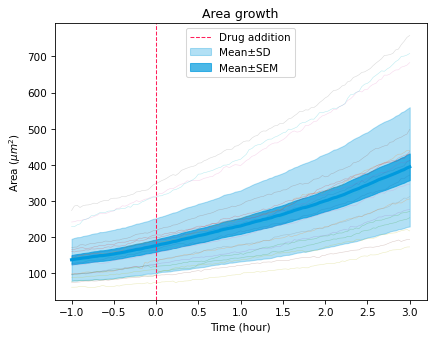

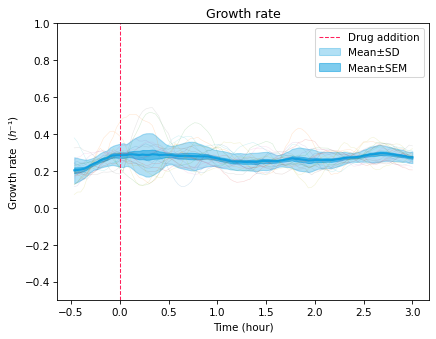

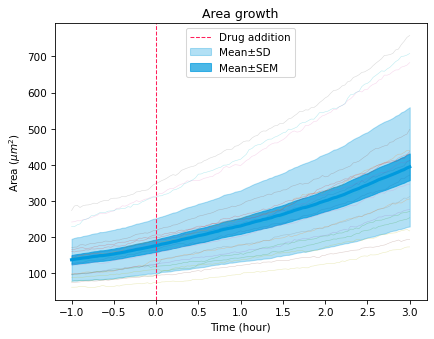

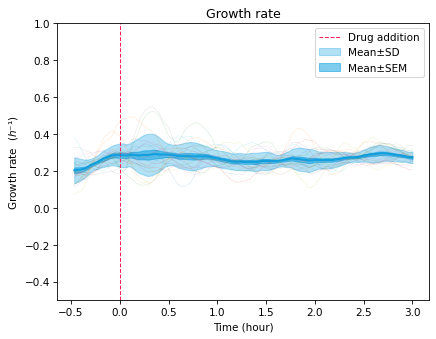

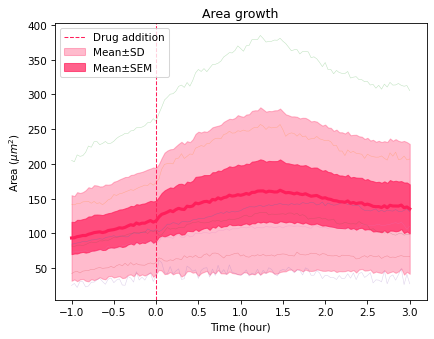

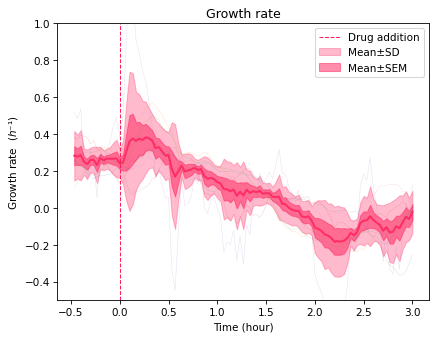

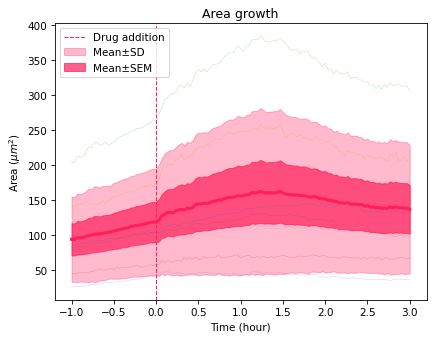

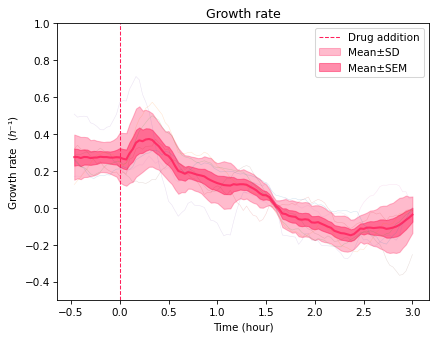

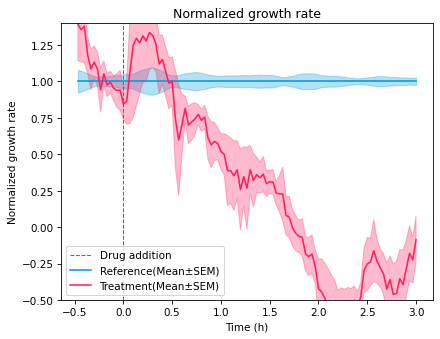

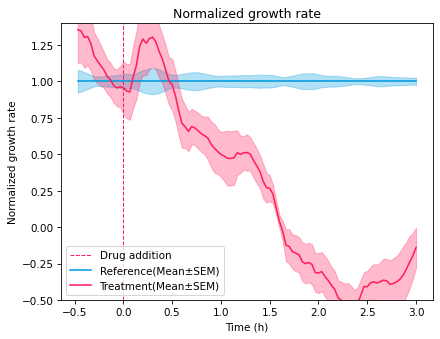

Created sus_time_array with 89 timepoints
Time range: -0.47h to 2.47h


In [27]:
# Comparative Growth Dynamics Analysis ready
ref_dir = SUSCEPTIBLE_REF_DIR
treat_dir = SUSCEPTIBLE_TREAT_DIR

def exp_growth_fit(x, a, b):
	return a * np.exp(b * x)

def get_areas_data(input_dir):
    file_list = os.listdir(input_dir)

    for file_name in file_list:
        if file_name.endswith('stacked_merged_areas_growth_data.pickle'):
            areas_file_path = os.path.join(input_dir, file_name)

    with open(areas_file_path, 'rb') as f:
        stacked_merged_areas_growth_data = pickle.load(f)
    
    return stacked_merged_areas_growth_data

def fit_exponential(data,rolling_number,divisor):
    fitted_chunk = int(rolling_number/divisor)
    # Define the exponential function
    def exponential(x, a, b):
        return a * np.exp(b * x)
    
    # Define a function to check if a value fits well with the fitted exponential function
    def is_good_fit(x, y, a, b, threshold=0.05):
        fitted_value = exponential(x, a, b)
        return abs((y - fitted_value) / y) <= threshold
    
    result = []

    # Loop over the data in chunks of 18
    for i in range(0, len(data)-1, fitted_chunk):
        chunk = data[i:i+fitted_chunk]
        # Fit the exponential function to the chunk
        try:
            popt, _ = curve_fit(exponential, range(len(chunk)), chunk, maxfev=5000)
        except RuntimeError:
            # Fitting failed, just append the chunk as is
            result.extend(chunk)
            continue

        # Check if each value in the chunk fits well with the fitted function
        for j, value in enumerate(chunk):
            if not is_good_fit(j, value, *popt):
                # Replace the value with the fitted value
                chunk[j] = exponential(j, *popt)
        result.extend(chunk)

    return result

def calculate_growth_rate_rolling(rolling_number, interval_time, area_data):
    growth_rate_rollings = []
    for i in range(rolling_number,len(area_data)):
        if i >= rolling_number: 
            time_rolling = [time for time in range(i-rolling_number,i)] 
            area_rolling = [value for value in area_data[i-rolling_number:i]]  
            p0 = [1, 0.0005]  # Initial parameter estimates [a, b]                                   
            popt, _ = curve_fit(exp_growth_fit, time_rolling, area_rolling, p0=p0)  #return popt[0] = a and popt[1] = b
            growth_rate_rollings.append(popt[1]/interval_time*60)
    
    return growth_rate_rollings

def find_means_std_sem(data):
    stacked_data = np.vstack(data)
    stacked_data_means = np.mean(stacked_data, axis=0)
    stacked_data_std_dev = np.std(stacked_data, axis=0, ddof=1)
    stacked_data_std_err = stats.sem(stacked_data, axis=0, ddof=1)
    
    return stacked_data_means, stacked_data_std_dev, stacked_data_std_err

def plot_area_growth(corrected_areas_plot, interval_time, num_frame, corrected_areas_column_means, corrected_areas_column_std_dev, corrected_areas_column_std_err, color):
    time_plot = [time*(interval_time/60)-1 for time in range(0, num_frame)]  #the interval time between two frames is 10 min,
   
    # Create a plot
    plt.figure(facecolor='white')  # Optional: Set the figure size
    # Add a vertical line at x=0
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition') ##e64b35
    plt.plot(time_plot, corrected_areas_plot.T, lw = 0.5, alpha=0.3)  # Transpose the data to plot columns as separate lines
    plt.plot(time_plot, corrected_areas_column_means, lw = 3, color = color)
    plt.fill_between(time_plot, corrected_areas_column_means - corrected_areas_column_std_dev, 
                     corrected_areas_column_means + corrected_areas_column_std_dev, 
                     label='Mean±SD', alpha=0.3, color = color)
    plt.fill_between(time_plot, corrected_areas_column_means - corrected_areas_column_std_err, 
                     corrected_areas_column_means + corrected_areas_column_std_err, 
                     label='Mean±SEM', alpha=0.7, color = color)
    plt.xlabel('Time (hour)')
    plt.ylabel('Area'+ r' ($\mu m^2$) ')
    plt.title('Area growth')
    plt.legend()
    
def plot_growth_curve(stacked_growth_data, interval_time, rolling_number, num_frame, growth_mean, growth_std, growth_sem, color):
    time_plot_growth = [time*(interval_time/60)-1 for time in range(0, num_frame+rolling_number)] 

    # Create a plot
    plt.figure(facecolor='white')  # Optional: Set the figure size
    # Add a vertical line at x=0
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
    
    plt.plot(time_plot_growth[rolling_number:],stacked_growth_data.T, lw = 0.5, alpha=0.2)  # Transpose the data to plot columns as separate lines
    plt.plot(time_plot_growth[rolling_number:],growth_mean, lw = 2, alpha=0.8, color = color)
    plt.fill_between(time_plot_growth[rolling_number:], growth_mean - growth_std, growth_mean + growth_std, label='Mean±SD', alpha=0.3, color = color)
    plt.fill_between(time_plot_growth[rolling_number:], growth_mean - growth_sem, growth_mean + growth_sem, label='Mean±SEM', alpha=0.5, color = color)
    plt.xlabel('Time (hour)')
    plt.ylabel('Growth rate '+ r' ($h⁻¹$) ')
    plt.title('Growth rate')
    plt.ylim(-0.5,1)
    plt.legend()  

def normalize_lists(list_a, list_b):
    # Check if both lists have the same length
    if len(list_a) != len(list_b):
        raise ValueError("Lists must have the same length")

    # Normalize values
    normalized_result = [a / b for a, b in zip(list_a, list_b)]

    return normalized_result

#Experiment parameters
rolling_number = 16 #number of data points for fitting M. smegmatis (2 mins intervals for 4 hours) (rolling of 16 points = 30 min)
interval_time = 2 #interval between frames in minutes
pixel_area = 0.0733**2 #the pixel size is 73.3 nm at 100x*1.5x magnification in Nikon6

#####################################################################################
#reference
ref_areas_data = get_areas_data(ref_dir)
ref_areas_data = ref_areas_data*pixel_area

# calculate and plot area
ref_areas_means, ref_areas_std, ref_areas_sem = find_means_std_sem(ref_areas_data)
num_pos_areas, num_frame_areas = ref_areas_data.shape
plot_area_growth(ref_areas_data, interval_time, num_frame_areas, ref_areas_means, ref_areas_std, ref_areas_sem, color='#009ADE') ##0D4A70
plt.savefig(os.path.join(ref_dir,"EXP-23-BZ3167_REFERENCE-Area.svg"))
plt.show()

# calculate and plot growth rate
ref_growth_rates = []
for pos_area in ref_areas_data:
    ref_pos_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area)
    ref_growth_rates.append(ref_pos_growth_rate)

ref_growth_means, ref_growth_std, ref_growth_sem = find_means_std_sem(ref_growth_rates)

stacked_ref_growth_rates = np.vstack(ref_growth_rates)
num_pos, num_frame = stacked_ref_growth_rates.shape
plot_growth_curve(stacked_ref_growth_rates, interval_time, rolling_number, num_frame, ref_growth_means, ref_growth_std, ref_growth_sem, color = '#009ADE')
plt.savefig(os.path.join(ref_dir,"EXP-23-BZ3167_REFERENCE-Growth_rate.svg"))
plt.show()

#calculate and plot area (fit)
ref_fit_areas = []
for pos_area in ref_areas_data:
    ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 2)
    ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 1)
    ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 0.5)
    ref_fit_areas.append(ref_pos_fit_area)
    
ref_fit_areas_means, ref_fit_areas_std, ref_fit_areas_sem = find_means_std_sem(ref_fit_areas)
stacked_fit_areas = np.vstack(ref_fit_areas)
num_pos_fit_areas, num_frame_fit_areas = stacked_fit_areas.shape
plot_area_growth(stacked_fit_areas, interval_time, num_frame_fit_areas, ref_fit_areas_means, ref_fit_areas_std, ref_fit_areas_sem, color='#009ADE')
plt.savefig(os.path.join(ref_dir,"EXP-23-BZ3167_REFERENCE-Area-fit.svg"))
plt.show()


#calculate and plot growth rate
ref_fit_growth_rates = []
for pos_area_fit in stacked_fit_areas:
    ref_pos_fit_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area_fit)
    ref_fit_growth_rates.append(ref_pos_fit_growth_rate)

ref_fit_growth_means, ref_fit_growth_std, ref_fit_growth_sem = find_means_std_sem(ref_fit_growth_rates)

stacked_ref_fit_growth_rates = np.vstack(ref_fit_growth_rates)
num_pos_fit, num_frame_fit = stacked_ref_fit_growth_rates.shape

plot_growth_curve(stacked_ref_fit_growth_rates, interval_time, rolling_number, num_frame_fit, ref_fit_growth_means, ref_fit_growth_std, ref_fit_growth_sem, color = '#009ADE')
plt.savefig(os.path.join(ref_dir,"EXP-23-BZ3167_REFERENCE-Growth-rate-fit.svg"))
plt.show()

#####################################################################################
#treatment
treat_areas_data = get_areas_data(treat_dir)
treat_areas_data = treat_areas_data*pixel_area

#calculate and plot area
treat_areas_means, treat_areas_std, treat_areas_sem = find_means_std_sem(treat_areas_data)
num_pos_areas, num_frame_areas = treat_areas_data.shape

plot_area_growth(treat_areas_data, interval_time, num_frame_areas, treat_areas_means, treat_areas_std, treat_areas_sem, color='#FF1F5B')
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_TREAT-Area.svg"))
plt.show()

#Calculate and plot growth rates
treat_growth_rates = []
for pos_area in treat_areas_data:
    treat_pos_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area)
    treat_growth_rates.append(treat_pos_growth_rate)

treat_growth_means, treat_growth_std, treat_growth_sem = find_means_std_sem(treat_growth_rates)

stacked_treat_growth_rates = np.vstack(treat_growth_rates)
num_pos, num_frame = stacked_treat_growth_rates.shape

plot_growth_curve(stacked_treat_growth_rates, interval_time, rolling_number, num_frame, treat_growth_means, treat_growth_std, treat_growth_sem, color = '#FF1F5B')
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_TREATMENT-Growth-rate.svg"))
plt.show()

#Calculate and plot growth rates (from fitted area data)
treat_fit_areas = []
for pos_area in treat_areas_data:
    treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 2)
    treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 1)
    treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 0.5)
    treat_fit_areas.append(treat_pos_fit_area)
    
treat_fit_areas_means, treat_fit_areas_std, treat_fit_areas_sem = find_means_std_sem(treat_fit_areas)
treat_stacked_fit_areas = np.vstack(treat_fit_areas)
num_pos_fit_areas, num_frame_fit_areas = treat_stacked_fit_areas.shape
plot_area_growth(treat_stacked_fit_areas, interval_time, num_frame_fit_areas, treat_fit_areas_means, treat_fit_areas_std, treat_fit_areas_sem, color='#FF1F5B')
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_TREAT-Area-fit.svg"))
plt.show()

#calculate and plot growth rate
treat_fit_growth_rates = []
for pos_area_fit in treat_stacked_fit_areas:
    treat_pos_fit_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area_fit)
    treat_fit_growth_rates.append(treat_pos_fit_growth_rate)

treat_fit_growth_means, treat_fit_growth_std, treat_fit_growth_sem = find_means_std_sem(treat_fit_growth_rates)

stacked_treat_fit_growth_rates = np.vstack(treat_fit_growth_rates)
num_pos_fit, num_frame_fit = stacked_treat_fit_growth_rates.shape

plot_growth_curve(stacked_treat_fit_growth_rates, interval_time, rolling_number, num_frame_fit, treat_fit_growth_means, treat_fit_growth_std, treat_fit_growth_sem, color = '#FF1F5B')
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_TREATMENT-Growth-rate-fit.svg"))
plt.show()

#####################################################################################
#normalization of reference means, standard deviations, SEMs to the reference means
normalized_ref_ref_means = normalize_lists(ref_growth_means,ref_growth_means)
normalized_ref_ref_means = np.array(normalized_ref_ref_means)

normalized_ref_ref_std = normalize_lists(ref_growth_std,ref_growth_means)
normalized_ref_ref_std = np.array(normalized_ref_ref_std)

normalized_ref_ref_sem = normalize_lists(ref_growth_sem,ref_growth_means)
normalized_ref_ref_sem = np.array(normalized_ref_ref_sem)

#normalization of treatment means, standard deviations, SEMs to the reference means
normalized_treat_ref_means = normalize_lists(treat_growth_means,ref_growth_means)
normalized_treat_ref_means = np.array(normalized_treat_ref_means)

normalized_treat_ref_std = normalize_lists(treat_growth_std,ref_growth_means)
normalized_treat_ref_std = np.array(normalized_treat_ref_std)

normalized_treat_ref_sem = normalize_lists(treat_growth_sem,ref_growth_means)
normalized_treat_ref_sem = np.array(normalized_treat_ref_sem)

time_plot_growth = [time*(interval_time/60)-1 for time in range(0, num_frame+rolling_number)] 

plt.figure(facecolor='white')
# Add a vertical line at x=0
plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
plt.plot(time_plot_growth[rolling_number:], normalized_ref_ref_means, label='Reference(Mean±SEM)', color = '#009ADE')
plt.fill_between(time_plot_growth[rolling_number:], normalized_ref_ref_means - normalized_ref_ref_sem, normalized_ref_ref_means + normalized_ref_ref_sem, alpha=0.3, color = '#009ADE')
plt.plot(time_plot_growth[rolling_number:], normalized_treat_ref_means, label='Treatment(Mean±SEM)', color = '#FF1F5B')
plt.fill_between(time_plot_growth[rolling_number:], normalized_treat_ref_means - normalized_treat_ref_sem, normalized_treat_ref_means + normalized_treat_ref_sem, alpha=0.3, color = '#FF1F5B')
plt.xlabel('Time (h)')
plt.ylabel('Normalized growth rate')
plt.legend()
plt.title('Normalized growth rate')
plt.ylim(-0.5,1.4)
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_NORMALIZED-Growth_rate.svg"))
plt.show()

#####################################################################################
#normalization of reference means, standard deviations, SEMs to the reference means
normalized_fit_ref_ref_means = normalize_lists(ref_fit_growth_means,ref_fit_growth_means)
normalized_fit_ref_ref_means = np.array(normalized_fit_ref_ref_means)

normalized_fit_ref_ref_std = normalize_lists(ref_fit_growth_std,ref_fit_growth_means)
normalized_fit_ref_ref_std = np.array(normalized_fit_ref_ref_std)

normalized_fit_ref_ref_sem = normalize_lists(ref_fit_growth_sem,ref_fit_growth_means)
normalized_fit_ref_ref_sem = np.array(normalized_fit_ref_ref_sem)

#normalization of treatment means, standard deviations, SEMs to the reference means
normalized_fit_treat_ref_means = normalize_lists(treat_fit_growth_means,ref_fit_growth_means)
normalized_fit_treat_ref_means = np.array(normalized_fit_treat_ref_means)

normalized_fit_treat_ref_std = normalize_lists(treat_fit_growth_std,ref_fit_growth_means)
normalized_fit_treat_ref_std = np.array(normalized_fit_treat_ref_std)

normalized_fit_treat_ref_sem = normalize_lists(treat_fit_growth_sem,ref_fit_growth_means)
normalized_fit_treat_ref_sem = np.array(normalized_fit_treat_ref_sem)

time_plot_growth_fit = [time*(interval_time/60)-1 for time in range(0, num_frame_fit+rolling_number)] 

plt.figure(facecolor='white')
# Add a vertical line at x=0
plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
plt.plot(time_plot_growth_fit[rolling_number:], normalized_fit_ref_ref_means, label='Reference(Mean±SEM)', color = '#009ADE')
plt.fill_between(time_plot_growth_fit[rolling_number:], normalized_fit_ref_ref_means - normalized_fit_ref_ref_sem, normalized_fit_ref_ref_means + normalized_fit_ref_ref_sem, alpha=0.3, color = '#009ADE')
plt.plot(time_plot_growth_fit[rolling_number:], normalized_fit_treat_ref_means, label='Treatment(Mean±SEM)', color = '#FF1F5B')
plt.fill_between(time_plot_growth_fit[rolling_number:], normalized_fit_treat_ref_means - normalized_fit_treat_ref_sem, normalized_fit_treat_ref_means + normalized_fit_treat_ref_sem, alpha=0.3, color = '#FF1F5B')
plt.xlabel('Time (h)')
plt.ylabel('Normalized growth rate')
plt.legend()
plt.title('Normalized growth rate')
plt.ylim(-0.5,1.4)
plt.savefig(os.path.join(treat_dir,"EXP-23-BZ3167_NORMALIZED-Growth-rate-fit.svg"))
plt.show()
# =============================================================================
# CREATE TIME ARRAY FOR SUSCEPTIBLE DATA (needed for advanced TTD analysis)
# =============================================================================
sus_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, num_frame_fit)])
print(f"Created sus_time_array with {len(sus_time_array)} timepoints")
print(f"Time range: {sus_time_array[0]:.2f}h to {sus_time_array[-1]:.2f}h")


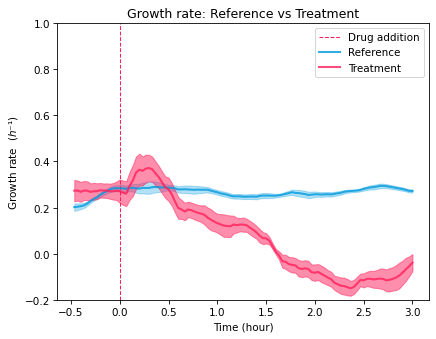

In [28]:
# growth curve ready
def plot_growth_curve_two(stacked_growth_data, interval_time, rolling_number, num_frame, growth_mean, growth_std, growth_sem, stacked_growth_data2, growth_mean2, growth_std2, growth_sem2, color, color2):
    time_plot_growth = [time*(interval_time/60)-1 for time in range(0, num_frame+rolling_number)] 

    # Create a plot
    plt.figure(facecolor='white')  # Optional: Set the figure size
    # Add a vertical line at x=0
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')

    # Plot Reference (Blue)
    plt.plot(time_plot_growth[rolling_number:], growth_mean, lw=2, alpha=0.8, color=color, label='Reference')
    plt.fill_between(time_plot_growth[rolling_number:], growth_mean - growth_sem, growth_mean + growth_sem, 
                     alpha=0.3, color=color) # Removed label here to avoid duplicate legend entries
    
    # Plot Treatment (Red)
    plt.plot(time_plot_growth[rolling_number:], growth_mean2, lw=2, alpha=0.8, color=color2, label='Treatment')
    plt.fill_between(time_plot_growth[rolling_number:], growth_mean2 - growth_sem2, growth_mean2 + growth_sem2, 
                     alpha=0.5, color=color2)
    
    plt.xlabel('Time (hour)')
    plt.ylabel('Growth rate '+ r' ($h⁻¹$) ')
    plt.title('Growth rate: Reference vs Treatment')
    
    # FIX: Expanded Y-limit to catch fast growth (up to 1.0)
    plt.ylim(-0.2, 1.0) 
    plt.legend()   

#####################################################################################
# Plotting growth curve of both reference and treatment in the same graph
plot_growth_curve_two(stacked_ref_fit_growth_rates, interval_time, rolling_number, num_frame_fit, ref_fit_growth_means, ref_fit_growth_std, ref_fit_growth_sem, 
                      stacked_treat_fit_growth_rates, treat_fit_growth_means, treat_fit_growth_std, treat_fit_growth_sem, 
                      color='#009ADE', color2='#FF1F5B')

# FIX: Corrected filename to match your experiment ID
plt.savefig(os.path.join(treat_dir, "EXP-23-BZ3167_TREATMENT_and_REFERENCE-Growth-rate-fit.svg"))
plt.show()

Attempting to load 5 HR Reference positions...
Successfully loaded 5 positions.
Trimming data to 289 frames for stacking.


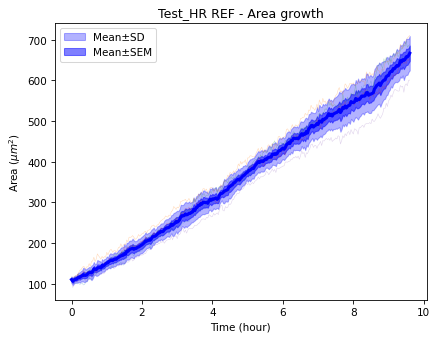

Test_HR REF: Loaded 5 positions, 289 frames


In [29]:
# Test_HR REF data analysis ready
hr_main_dir_ref = HR_REF_DIR
hr_all_positions_ref = list(range(101,106))  # Test_HR has Pos101-105
hr_positions_ref = [pos for pos in hr_all_positions_ref]

hr_list_position_dirs = []

for position in hr_positions_ref:
    if position < 100:
        dir_string = 'Pos0' + str(position)
    else:
        dir_string = 'Pos' + str(position)
    
    directory = os.path.join(hr_main_dir_ref, dir_string)
    hr_list_position_dirs.append(directory)

phase_dir_name = 'PreprocessedPhaseMasks'
hr_merged_areas_growth_data = []

print(f"Attempting to load {len(hr_list_position_dirs)} HR Reference positions...")

for position_directory in hr_list_position_dirs:
    if not os.path.exists(position_directory):
        continue
        
    folder_list = os.listdir(position_directory)
    
    for folder_name in folder_list:
        if folder_name == phase_dir_name:
            input_dir = os.path.join(position_directory,folder_name)
            if not os.path.exists(input_dir): continue
            
            file_list = os.listdir(input_dir)
            
            for file_name in file_list:
                if file_name.endswith('growth_areas.pickle'):
                    areas_file_path = os.path.join(input_dir, file_name)
                    with open(areas_file_path, 'rb') as f:
                        areas_growth_data = pickle.load(f)
                        hr_merged_areas_growth_data.append(areas_growth_data)

# ==========================================
# TRIM & STACK (Safety Fix)
# ==========================================
if len(hr_merged_areas_growth_data) > 0:
    # Find shortest length to prevent crashes
    lengths = [len(arr) for arr in hr_merged_areas_growth_data]
    min_length = min(lengths)
    
    print(f"Successfully loaded {len(hr_merged_areas_growth_data)} positions.")
    print(f"Trimming data to {min_length} frames for stacking.")

    # Trim to minimum length
    trimmed_data = [arr[:min_length] for arr in hr_merged_areas_growth_data]

    # Stack merged area growth
    hr_stacked_ref_areas = np.vstack(trimmed_data)

    with open(os.path.join(hr_main_dir_ref,"stacked_merged_areas_growth_data.pickle"), "wb") as file:
        pickle.dump(hr_stacked_ref_areas, file)
            
    hr_areas_column_means = np.mean(hr_stacked_ref_areas, axis=0)
    hr_areas_column_std_dev = np.std(hr_stacked_ref_areas, axis=0, ddof=1)
    hr_areas_column_std_err = stats.sem(hr_stacked_ref_areas, axis=0, ddof=1)

    # Extract the number of positions and of frames
    hr_num_pos, hr_num_frame = hr_stacked_ref_areas.shape

    time_plot = [time*(2/60) for time in range(0, hr_num_frame)]
    corrected_areas_plot = hr_stacked_ref_areas*(0.0733**2)
    corrected_areas_column_means = hr_areas_column_means*(0.0733**2)
    corrected_areas_column_std_dev = hr_areas_column_std_dev*(0.0733**2)
    corrected_areas_column_std_err = hr_areas_column_std_err*(0.0733**2)

    # Create a plot
    plt.figure(facecolor='white')
    plt.plot(time_plot, corrected_areas_plot.T, lw = 0.5, alpha=0.3)
    plt.plot(time_plot, corrected_areas_column_means, lw = 3, color = 'blue')
    plt.fill_between(time_plot, corrected_areas_column_means - corrected_areas_column_std_dev, 
                    corrected_areas_column_means + corrected_areas_column_std_dev, 
                    label='Mean±SD', alpha=0.3, color = 'blue')
    plt.fill_between(time_plot, corrected_areas_column_means - corrected_areas_column_std_err, 
                    corrected_areas_column_means + corrected_areas_column_std_err, 
                    label='Mean±SEM', alpha=0.5, color = 'blue')
    plt.xlabel('Time (hour)')
    plt.ylabel(r'Area ($\mu m^2$)')
    plt.title('Test_HR REF - Area growth')
    plt.legend()
    plt.show()
    print(f"Test_HR REF: Loaded {hr_num_pos} positions, {hr_num_frame} frames")
else:
    print("Error: No data found.")

Attempting to load 5 HR Reference positions...
Successfully loaded 5 positions.
Lengths vary from 289 to 289.
Trimming data to 289 frames for stacking.


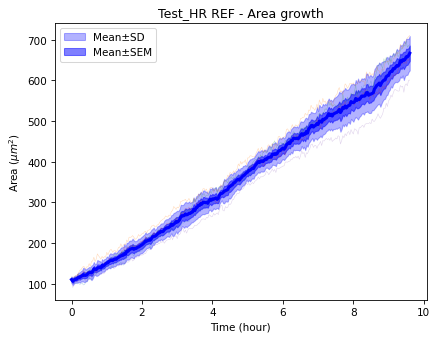

Test_HR REF: Final Data Shape: (5, 289)


In [30]:
# 1. SETUP: Define HR Reference Positions (Pos101-105) ready 1. The First Cell (HR Reference) ready
# ==========================================
hr_main_dir_ref = HR_REF_DIR
hr_all_positions_ref = list(range(101, 106))  # Test_HR has Pos101-105
hr_positions_ref = [pos for pos in hr_all_positions_ref]

hr_list_position_dirs = []
for position in hr_positions_ref:
    if position < 100:
        dir_string = 'Pos0' + str(position)
    else:
        dir_string = 'Pos' + str(position)
    
    directory = os.path.join(hr_main_dir_ref, dir_string)
    hr_list_position_dirs.append(directory)

phase_dir_name = 'PreprocessedPhaseMasks'

# ==========================================
# 2. LOAD DATA
# ==========================================
hr_merged_areas_growth_data = []

print(f"Attempting to load {len(hr_list_position_dirs)} HR Reference positions...")

for position_directory in hr_list_position_dirs:
    if not os.path.exists(position_directory):
        print(f"Skipping missing directory: {position_directory}")
        continue

    folder_list = os.listdir(position_directory)
    
    for folder_name in folder_list:
        if folder_name == phase_dir_name:
            input_dir = os.path.join(position_directory, folder_name)
            if not os.path.exists(input_dir):
                continue
            
            file_list = os.listdir(input_dir)
            for file_name in file_list:
                if file_name.endswith('growth_areas.pickle'):
                    areas_file_path = os.path.join(input_dir, file_name)
                    with open(areas_file_path, 'rb') as f:
                        areas_growth_data = pickle.load(f)
                        hr_merged_areas_growth_data.append(areas_growth_data)

# ==========================================
# 3. TRIM & STACK (Safety Fix)
# ==========================================
if len(hr_merged_areas_growth_data) > 0:
    # Find shortest length to prevent crashes
    lengths = [len(arr) for arr in hr_merged_areas_growth_data]
    min_length = min(lengths)
    
    print(f"Successfully loaded {len(hr_merged_areas_growth_data)} positions.")
    print(f"Lengths vary from {min(lengths)} to {max(lengths)}.")
    print(f"Trimming data to {min_length} frames for stacking.")

    # Trim to minimum length
    trimmed_hr_areas = [arr[:min_length] for arr in hr_merged_areas_growth_data]
    
    # Stack
    hr_stacked_ref_areas = np.vstack(trimmed_hr_areas)

    # Save
    with open(os.path.join(hr_main_dir_ref, "stacked_merged_areas_growth_data.pickle"), "wb") as file:
        pickle.dump(hr_stacked_ref_areas, file)

    # ==========================================
    # 4. PLOT
    # ==========================================
    hr_areas_column_means = np.mean(hr_stacked_ref_areas, axis=0)
    hr_areas_column_std_dev = np.std(hr_stacked_ref_areas, axis=0, ddof=1)
    hr_areas_column_std_err = stats.sem(hr_stacked_ref_areas, axis=0, ddof=1)

    hr_num_pos, hr_num_frame = hr_stacked_ref_areas.shape

    time_plot = [time*(2/60) for time in range(0, hr_num_frame)]
    corrected_areas_plot = hr_stacked_ref_areas*(0.0733**2)
    corrected_areas_column_means = hr_areas_column_means*(0.0733**2)
    corrected_areas_column_std_dev = hr_areas_column_std_dev*(0.0733**2)
    corrected_areas_column_std_err = hr_areas_column_std_err*(0.0733**2)

    plt.figure(facecolor='white')
    plt.plot(time_plot, corrected_areas_plot.T, lw=0.5, alpha=0.3)
    plt.plot(time_plot, corrected_areas_column_means, lw=3, color='blue')
    plt.fill_between(time_plot, corrected_areas_column_means - corrected_areas_column_std_dev, 
                     corrected_areas_column_means + corrected_areas_column_std_dev, 
                     label='Mean±SD', alpha=0.3, color='blue')
    plt.fill_between(time_plot, corrected_areas_column_means - corrected_areas_column_std_err, 
                     corrected_areas_column_means + corrected_areas_column_std_err, 
                     label='Mean±SEM', alpha=0.5, color='blue')
    plt.xlabel('Time (hour)')
    plt.ylabel(r'Area ($\mu m^2$)')
    plt.title('Test_HR REF - Area growth')
    plt.legend()
    plt.show()
    
    print(f"Test_HR REF: Final Data Shape: {hr_stacked_ref_areas.shape}")

else:
    print("Error: No HR Reference data found.")

Attempting to load 5 HR Treated positions...
Successfully loaded 5 positions.
Lengths vary from 289 to 289.
Trimming data to 289 frames for stacking.


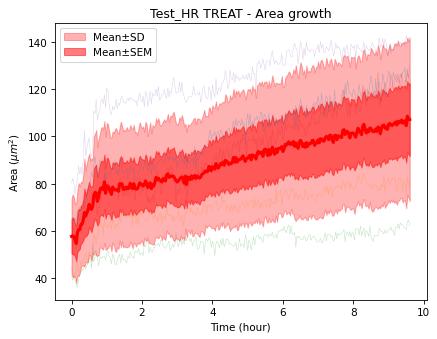

Test_HR TREAT: Final Data Shape: (5, 289)


In [31]:
# 1. SETUP: Define HR Treated Positions (Pos201-205) ready 2. The Second Cell (HR Treated) ready
# ==========================================
hr_main_dir_treat = HR_TREAT_DIR
hr_all_positions_treat = list(range(201, 206))  # Test_HR has Pos201-205
hr_positions_treat = [pos for pos in hr_all_positions_treat]

hr_list_position_dirs_treat = []

for position in hr_positions_treat:
    if position < 100:
        dir_string = 'Pos0' + str(position)
    else:
        dir_string = 'Pos' + str(position)
    
    directory = os.path.join(hr_main_dir_treat, dir_string)
    hr_list_position_dirs_treat.append(directory)

phase_dir_name = 'PreprocessedPhaseMasks'

# ==========================================
# 2. LOAD DATA
# ==========================================
hr_merged_areas_growth_data_treat = []

print(f"Attempting to load {len(hr_list_position_dirs_treat)} HR Treated positions...")

for position_directory in hr_list_position_dirs_treat:
    if not os.path.exists(position_directory):
        print(f"Skipping missing directory: {position_directory}")
        continue

    folder_list = os.listdir(position_directory)
    
    for folder_name in folder_list:
        if folder_name == phase_dir_name:
            input_dir = os.path.join(position_directory, folder_name)
            if not os.path.exists(input_dir):
                continue
            
            file_list = os.listdir(input_dir)
            for file_name in file_list:
                if file_name.endswith('growth_areas.pickle'):
                    areas_file_path = os.path.join(input_dir, file_name)
                    with open(areas_file_path, 'rb') as f:
                        areas_growth_data = pickle.load(f)
                        hr_merged_areas_growth_data_treat.append(areas_growth_data)

# ==========================================
# 3. TRIM & STACK (Safety Fix)
# ==========================================
if len(hr_merged_areas_growth_data_treat) > 0:
    # Find shortest length to prevent crashes
    lengths = [len(arr) for arr in hr_merged_areas_growth_data_treat]
    min_length = min(lengths)
    
    print(f"Successfully loaded {len(hr_merged_areas_growth_data_treat)} positions.")
    print(f"Lengths vary from {min(lengths)} to {max(lengths)}.")
    print(f"Trimming data to {min_length} frames for stacking.")

    # Trim to minimum length
    trimmed_data = [arr[:min_length] for arr in hr_merged_areas_growth_data_treat]
    
    # Stack
    hr_stacked_treat_areas = np.vstack(trimmed_data)

    # Save
    with open(os.path.join(hr_main_dir_treat, "stacked_merged_areas_growth_data.pickle"), "wb") as file:
        pickle.dump(hr_stacked_treat_areas, file)
        
    # ==========================================
    # 4. PLOT (Red for Treatment)
    # ==========================================
    hr_treat_areas_column_means = np.mean(hr_stacked_treat_areas, axis=0)
    hr_treat_areas_column_std_dev = np.std(hr_stacked_treat_areas, axis=0, ddof=1)
    hr_treat_areas_column_std_err = stats.sem(hr_stacked_treat_areas, axis=0, ddof=1)

    hr_num_pos_treat, hr_num_frame_treat = hr_stacked_treat_areas.shape

    time_plot_treat = [time*(2/60) for time in range(0, hr_num_frame_treat)]
    corrected_treat_areas_plot = hr_stacked_treat_areas*(0.0733**2)
    corrected_treat_areas_column_means = hr_treat_areas_column_means*(0.0733**2)
    corrected_treat_areas_column_std_dev = hr_treat_areas_column_std_dev*(0.0733**2)
    corrected_treat_areas_column_std_err = hr_treat_areas_column_std_err*(0.0733**2)

    plt.figure(facecolor='white')
    plt.plot(time_plot_treat, corrected_treat_areas_plot.T, lw=0.5, alpha=0.3)
    plt.plot(time_plot_treat, corrected_treat_areas_column_means, lw=3, color='red')
    plt.fill_between(time_plot_treat, corrected_treat_areas_column_means - corrected_treat_areas_column_std_dev, 
                     corrected_treat_areas_column_means + corrected_treat_areas_column_std_dev, 
                     label='Mean±SD', alpha=0.3, color='red')
    plt.fill_between(time_plot_treat, corrected_treat_areas_column_means - corrected_treat_areas_column_std_err, 
                     corrected_treat_areas_column_means + corrected_treat_areas_column_std_err, 
                     label='Mean±SEM', alpha=0.5, color='red')
    plt.xlabel('Time (hour)')
    plt.ylabel(r'Area ($\mu m^2$)')
    plt.title('Test_HR TREAT - Area growth')
    plt.legend()
    plt.show()

    print(f"Test_HR TREAT: Final Data Shape: {hr_stacked_treat_areas.shape}")

else:
    print("Error: No HR Treated data found.")

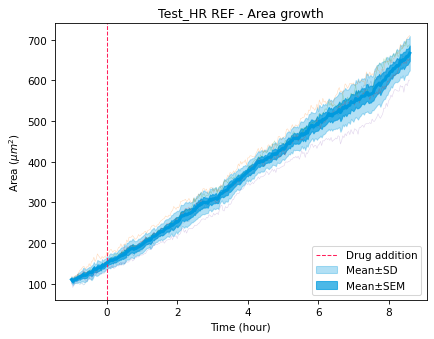

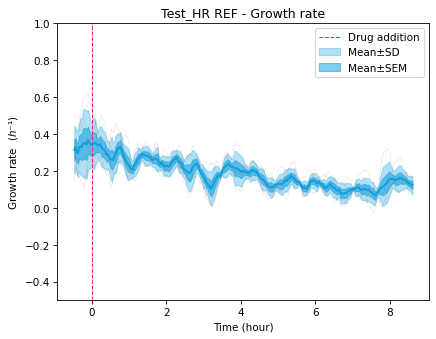

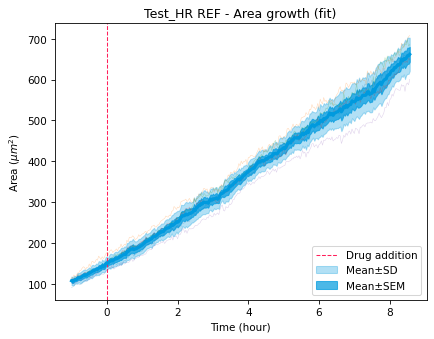

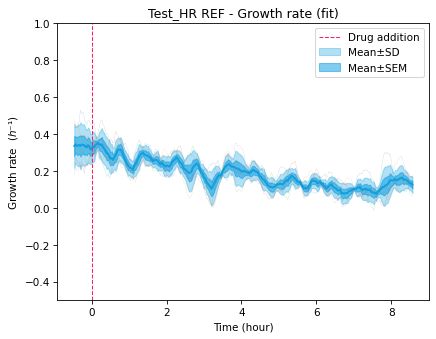

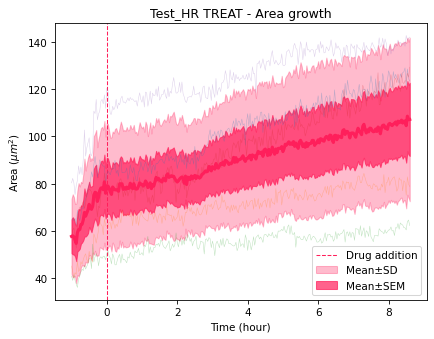

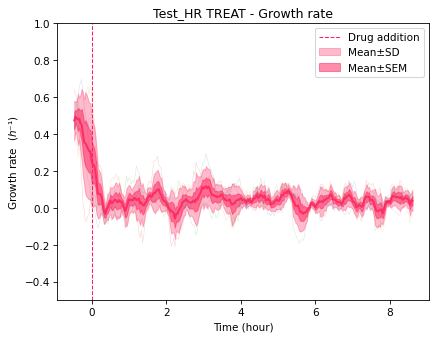

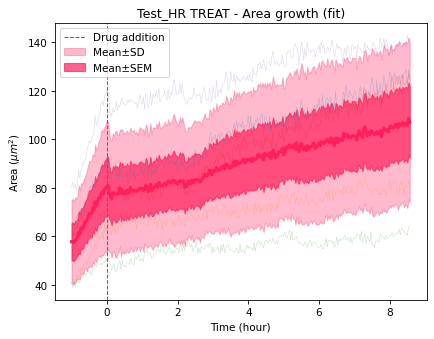

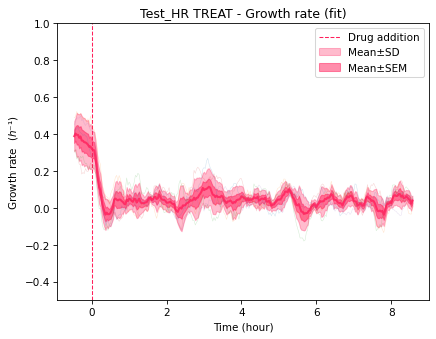

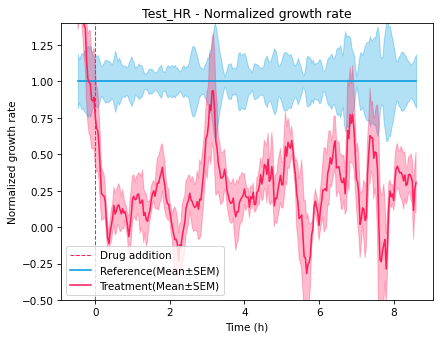

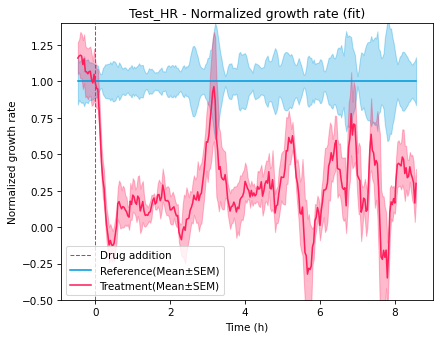

Created hr_time_array with 256 timepoints
Test_HR Analysis Complete!


In [32]:
# Test_HR Full Growth Rate Normalization Analysis ready
hr_ref_dir = HR_REF_DIR
hr_treat_dir = HR_TREAT_DIR

# Ensure parameters exist (inheriting from previous cells)
if 'rolling_number' not in locals():
    rolling_number = 16
    interval_time = 2
    pixel_area = 0.0733**2

# Reference analysis
hr_ref_areas_data = get_areas_data(hr_ref_dir)
hr_ref_areas_data = hr_ref_areas_data * pixel_area

# Calculate and plot area
hr_ref_areas_means, hr_ref_areas_std, hr_ref_areas_sem = find_means_std_sem(hr_ref_areas_data)
hr_num_pos_areas, hr_num_frame_areas = hr_ref_areas_data.shape
plot_area_growth(hr_ref_areas_data, interval_time, hr_num_frame_areas, hr_ref_areas_means, hr_ref_areas_std, hr_ref_areas_sem, color='#009ADE')
plt.title('Test_HR REF - Area growth')
plt.savefig(os.path.join(hr_ref_dir,"Test_HR_REFERENCE-Area.svg"))
plt.show()

# Calculate and plot growth rate
hr_ref_growth_rates = []
for pos_area in hr_ref_areas_data:
    hr_ref_pos_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area)
    hr_ref_growth_rates.append(hr_ref_pos_growth_rate)

hr_ref_growth_means, hr_ref_growth_std, hr_ref_growth_sem = find_means_std_sem(hr_ref_growth_rates)

hr_stacked_ref_growth_rates = np.vstack(hr_ref_growth_rates)
hr_num_pos, hr_num_frame = hr_stacked_ref_growth_rates.shape
plot_growth_curve(hr_stacked_ref_growth_rates, interval_time, rolling_number, hr_num_frame, hr_ref_growth_means, hr_ref_growth_std, hr_ref_growth_sem, color='#009ADE')
plt.title('Test_HR REF - Growth rate')
plt.savefig(os.path.join(hr_ref_dir,"Test_HR_REFERENCE-Growth_rate.svg"))
plt.show()

# Calculate and plot area (fit) - Optimized to remove redundant calls
hr_ref_fit_areas = []
for pos_area in hr_ref_areas_data:
    # Use divisor 0.5 directly (matches the final value in your logic)
    hr_ref_pos_fit_area = fit_exponential(pos_area, rolling_number, 0.5)
    hr_ref_fit_areas.append(hr_ref_pos_fit_area)

hr_ref_fit_areas_means, hr_ref_fit_areas_std, hr_ref_fit_areas_sem = find_means_std_sem(hr_ref_fit_areas)
hr_stacked_fit_ref_areas = np.vstack(hr_ref_fit_areas)
hr_num_pos_fit_areas_ref, hr_num_frame_fit_areas_ref = hr_stacked_fit_ref_areas.shape
plot_area_growth(hr_stacked_fit_ref_areas, interval_time, hr_num_frame_fit_areas_ref, hr_ref_fit_areas_means, hr_ref_fit_areas_std, hr_ref_fit_areas_sem, color='#009ADE')
plt.title('Test_HR REF - Area growth (fit)')
plt.savefig(os.path.join(hr_ref_dir,"Test_HR_REFERENCE-Area-fit.svg"))
plt.show()

# Calculate and plot growth rate (from fitted area data)
hr_ref_fit_growth_rates = []
for pos_area_fit in hr_stacked_fit_ref_areas:
    hr_ref_pos_fit_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area_fit)
    hr_ref_fit_growth_rates.append(hr_ref_pos_fit_growth_rate)

hr_ref_fit_growth_means, hr_ref_fit_growth_std, hr_ref_fit_growth_sem = find_means_std_sem(hr_ref_fit_growth_rates)

hr_stacked_ref_fit_growth_rates = np.vstack(hr_ref_fit_growth_rates)
hr_num_pos_fit_ref, hr_num_frame_fit_ref = hr_stacked_ref_fit_growth_rates.shape
plot_growth_curve(hr_stacked_ref_fit_growth_rates, interval_time, rolling_number, hr_num_frame_fit_ref, hr_ref_fit_growth_means, hr_ref_fit_growth_std, hr_ref_fit_growth_sem, color = '#009ADE')
plt.title('Test_HR REF - Growth rate (fit)')
plt.savefig(os.path.join(hr_ref_dir,"Test_HR_REFERENCE-Growth-rate-fit.svg"))
plt.show()

#####################################################################################
# Treatment analysis
hr_treat_areas_data = get_areas_data(hr_treat_dir)
hr_treat_areas_data = hr_treat_areas_data * pixel_area

# Calculate and plot area
hr_treat_areas_means, hr_treat_areas_std, hr_treat_areas_sem = find_means_std_sem(hr_treat_areas_data)
hr_num_pos_areas_t, hr_num_frame_areas_t = hr_treat_areas_data.shape
plot_area_growth(hr_treat_areas_data, interval_time, hr_num_frame_areas_t, hr_treat_areas_means, hr_treat_areas_std, hr_treat_areas_sem, color='#FF1F5B')
plt.title('Test_HR TREAT - Area growth')
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_TREAT-Area.svg"))
plt.show()

# Calculate and plot growth rates
hr_treat_growth_rates = []
for pos_area in hr_treat_areas_data:
    hr_treat_pos_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area)
    hr_treat_growth_rates.append(hr_treat_pos_growth_rate)

hr_treat_growth_means, hr_treat_growth_std, hr_treat_growth_sem = find_means_std_sem(hr_treat_growth_rates)

hr_stacked_treat_growth_rates = np.vstack(hr_treat_growth_rates)
hr_num_pos_t, hr_num_frame_t = hr_stacked_treat_growth_rates.shape
plot_growth_curve(hr_stacked_treat_growth_rates, interval_time, rolling_number, hr_num_frame_t, hr_treat_growth_means, hr_treat_growth_std, hr_treat_growth_sem, color='#FF1F5B')
plt.title('Test_HR TREAT - Growth rate')
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_TREATMENT-Growth-rate.svg"))
plt.show()

# Calculate and plot area (fit) - Optimized
hr_treat_fit_areas = []
for pos_area in hr_treat_areas_data:
    hr_treat_pos_fit_area = fit_exponential(pos_area, rolling_number, 0.5)
    hr_treat_fit_areas.append(hr_treat_pos_fit_area)
    
hr_treat_fit_areas_means, hr_treat_fit_areas_std, hr_treat_fit_areas_sem = find_means_std_sem(hr_treat_fit_areas)
hr_treat_stacked_fit_areas = np.vstack(hr_treat_fit_areas)
hr_num_pos_fit_areas_treat, hr_num_frame_fit_areas_treat = hr_treat_stacked_fit_areas.shape
plot_area_growth(hr_treat_stacked_fit_areas, interval_time, hr_num_frame_fit_areas_treat, hr_treat_fit_areas_means, hr_treat_fit_areas_std, hr_treat_fit_areas_sem, color='#FF1F5B')
plt.title('Test_HR TREAT - Area growth (fit)')
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_TREAT-Area-fit.svg"))
plt.show()

# Calculate and plot growth rate (from fitted area data)
hr_treat_fit_growth_rates = []
for pos_area_fit in hr_treat_stacked_fit_areas:
    hr_treat_pos_fit_growth_rate = calculate_growth_rate_rolling(rolling_number, interval_time, pos_area_fit)
    hr_treat_fit_growth_rates.append(hr_treat_pos_fit_growth_rate)

hr_treat_fit_growth_means, hr_treat_fit_growth_std, hr_treat_fit_growth_sem = find_means_std_sem(hr_treat_fit_growth_rates)

hr_stacked_treat_fit_growth_rates = np.vstack(hr_treat_fit_growth_rates)
hr_num_pos_fit_t, hr_num_frame_fit_t = hr_stacked_treat_fit_growth_rates.shape

plot_growth_curve(hr_stacked_treat_fit_growth_rates, interval_time, rolling_number, hr_num_frame_fit_t, hr_treat_fit_growth_means, hr_treat_fit_growth_std, hr_treat_fit_growth_sem, color = '#FF1F5B')
plt.title('Test_HR TREAT - Growth rate (fit)')
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_TREATMENT-Growth-rate-fit.svg"))
plt.show()

#####################################################################################
# Normalization (raw)
hr_normalized_ref_means = normalize_lists(hr_ref_growth_means, hr_ref_growth_means)
hr_normalized_ref_means = np.array(hr_normalized_ref_means)

hr_normalized_ref_sem = normalize_lists(hr_ref_growth_sem, hr_ref_growth_means)
hr_normalized_ref_sem = np.array(hr_normalized_ref_sem)

hr_normalized_treat_means = normalize_lists(hr_treat_growth_means, hr_ref_growth_means)
hr_normalized_treat_means = np.array(hr_normalized_treat_means)

hr_normalized_treat_sem = normalize_lists(hr_treat_growth_sem, hr_ref_growth_means)
hr_normalized_treat_sem = np.array(hr_normalized_treat_sem)

hr_time_plot_growth = [time*(interval_time/60)-1 for time in range(0, hr_num_frame+rolling_number)]

plt.figure(facecolor='white')
plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
plt.plot(hr_time_plot_growth[rolling_number:], hr_normalized_ref_means, label='Reference(Mean±SEM)', color='#009ADE')
plt.fill_between(hr_time_plot_growth[rolling_number:], hr_normalized_ref_means - hr_normalized_ref_sem, hr_normalized_ref_means + hr_normalized_ref_sem, alpha=0.3, color='#009ADE')
plt.plot(hr_time_plot_growth[rolling_number:], hr_normalized_treat_means, label='Treatment(Mean±SEM)', color='#FF1F5B')
plt.fill_between(hr_time_plot_growth[rolling_number:], hr_normalized_treat_means - hr_normalized_treat_sem, hr_normalized_treat_means + hr_normalized_treat_sem, alpha=0.3, color='#FF1F5B')
plt.xlabel('Time (h)')
plt.ylabel('Normalized growth rate')
plt.legend()
plt.title('Test_HR - Normalized growth rate')
plt.ylim(-0.5, 1.4)
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_NORMALIZED-Growth_rate.svg"))
plt.show()

#####################################################################################
# Normalization (fit) to mirror Susceptible pipeline
hr_normalized_fit_ref_means = normalize_lists(hr_ref_fit_growth_means, hr_ref_fit_growth_means)
hr_normalized_fit_ref_means = np.array(hr_normalized_fit_ref_means)

hr_normalized_fit_ref_sem = normalize_lists(hr_ref_fit_growth_sem, hr_ref_fit_growth_means)
hr_normalized_fit_ref_sem = np.array(hr_normalized_fit_ref_sem)

hr_normalized_fit_treat_means = normalize_lists(hr_treat_fit_growth_means, hr_ref_fit_growth_means)
hr_normalized_fit_treat_means = np.array(hr_normalized_fit_treat_means)

hr_normalized_fit_treat_sem = normalize_lists(hr_treat_fit_growth_sem, hr_ref_fit_growth_means)
hr_normalized_fit_treat_sem = np.array(hr_normalized_fit_treat_sem)

hr_time_plot_growth_fit = [time*(interval_time/60)-1 for time in range(0, hr_num_frame_fit_ref+rolling_number)]

plt.figure(facecolor='white')
plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1, label='Drug addition')
plt.plot(hr_time_plot_growth_fit[rolling_number:], hr_normalized_fit_ref_means, label='Reference(Mean±SEM)', color='#009ADE')
plt.fill_between(hr_time_plot_growth_fit[rolling_number:], hr_normalized_fit_ref_means - hr_normalized_fit_ref_sem, hr_normalized_fit_ref_means + hr_normalized_fit_ref_sem, alpha=0.3, color='#009ADE')
plt.plot(hr_time_plot_growth_fit[rolling_number:], hr_normalized_fit_treat_means, label='Treatment(Mean±SEM)', color = '#FF1F5B')
plt.fill_between(hr_time_plot_growth_fit[rolling_number:], hr_normalized_fit_treat_means - hr_normalized_fit_treat_sem, hr_normalized_fit_treat_means + hr_normalized_fit_treat_sem, alpha=0.3, color = '#FF1F5B')
plt.xlabel('Time (h)')
plt.ylabel('Normalized growth rate')
plt.legend()
plt.title('Test_HR - Normalized growth rate (fit)')
plt.ylim(-0.5,1.4)
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_NORMALIZED-Growth-rate-fit.svg"))
plt.show()

# =============================================================================
# CREATE TIME ARRAY FOR HR DATA (Critical for TTD Method 6)
# =============================================================================
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, hr_num_frame_fit_ref)])
print(f"Created hr_time_array with {len(hr_time_array)} timepoints")

print("Test_HR Analysis Complete!")

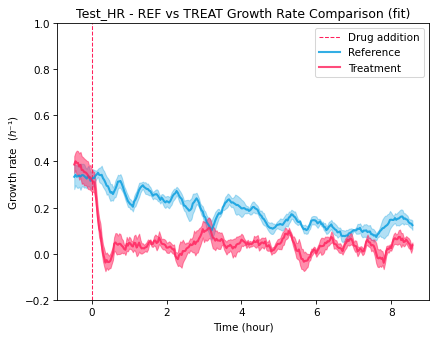

In [33]:
# Combined comparison plot: Test_HR REF vs TREAT (fit) ready
plot_growth_curve_two(hr_stacked_ref_fit_growth_rates, interval_time, rolling_number, hr_num_frame_fit_ref, 
                      hr_ref_fit_growth_means, hr_ref_fit_growth_std, hr_ref_fit_growth_sem,
                      hr_stacked_treat_fit_growth_rates, hr_treat_fit_growth_means, hr_treat_fit_growth_std, hr_treat_fit_growth_sem, 
                      color='#009ADE', color2='#FF1F5B')
plt.title('Test_HR - REF vs TREAT Growth Rate Comparison (fit)')
plt.savefig(os.path.join(hr_treat_dir,"Test_HR_REF_vs_TREAT_comparison_fit.svg"))
plt.show()

In [34]:
## TTD Analysis for Test_HR Dataset ready
print("="*70)
print("TTD Analysis: Test_HR (Heteroresistant)")
print("="*70)

# Time array for HR growth rates
# This ensures we match the exact length of the fitted data
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, hr_num_frame_fit_ref+rolling_number)])

print(f"Time Array Created. Range: {hr_time_array[0]:.2f}h to {hr_time_array[-1]:.2f}h")

TTD Analysis: Test_HR (Heteroresistant)
Time Array Created. Range: -0.47h to 8.57h


# Advanced TTD Methods - Beyond Pointwise Tests
In this section, we explore advanced methods for analyzing microbial growth data that go beyond traditional pointwise statistical tests. These methods leverage Gaussian Processes (GPs) and changepoint detection techniques to provide a more nuanced understanding of growth dynamics.
**Key Citations:**
- Midani et al. (2021) mSystems - Gaussian Process-based differential growth
- Tonner et al. (2017) Genome Research - GP regression for microbial populations  
- Truong et al. (2020) Signal Processing - Changepoint detection methods
- Efron & Tibshirani (1993) - Bootstrap resampling theory

## Method 1: Gaussian Process Regression (AMiGA-style)

**Citation:** Midani et al. (2021) mSystems; Tonner et al. (2017) Genome Research  
**Implementation based on:** [AMiGA GitHub](https://github.com/firasmidani/amiga) — Automated Microbial Growth Analysis

Instead of testing at each timepoint independently, we model both curves with Gaussian Processes and compute the **functional difference** with credible intervals. This avoids multiple testing issues and provides uncertainty quantification.

Running Method 1 (Gaussian Process) on Susceptible Data...
Shapes matching? Data: 105, Time: 105


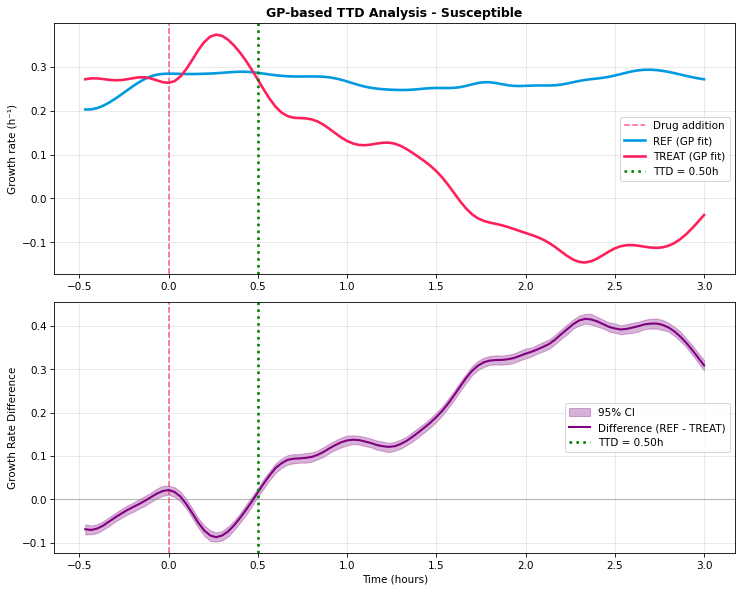

Susceptible TTD (GP): 0.5

Running Method 1 (Gaussian Process) on HR Data...


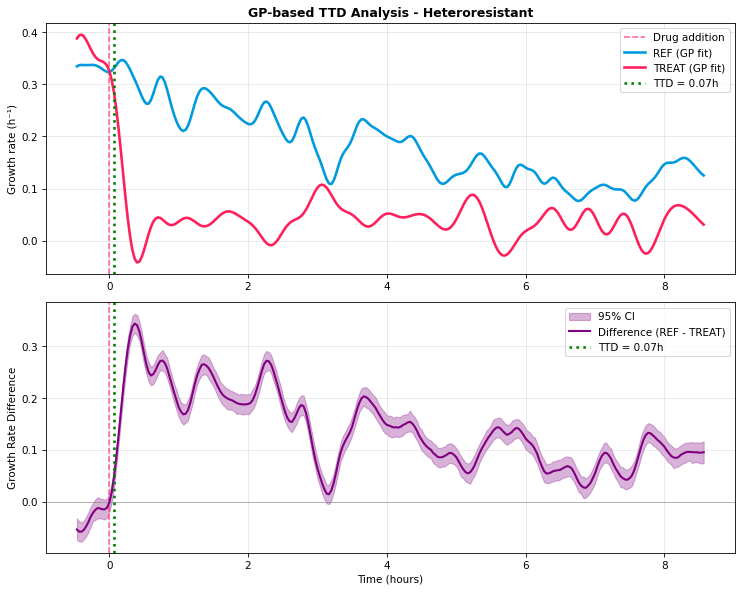

HR TTD (GP): 0.06666666666666665


In [35]:
# Amiga ready
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# ==========================================
# 1. DEFINE FUNCTIONS
# ==========================================
def fit_gp_to_growth_curve(time_array, growth_data, n_posterior_samples=100):
    """Fit a Gaussian Process to growth rate data with robust error handling."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Use mean across positions as the curve to fit
        y_mean = np.nanmean(growth_data, axis=0)
        
        # Handle NaN values
        valid_mask = ~np.isnan(y_mean)
        if np.sum(valid_mask) < 5:
            return None, y_mean, None, None
        
        # Reshape for sklearn
        X = time_array[valid_mask].reshape(-1, 1)
        y = y_mean[valid_mask]
        
        # Normalize data for numerical stability
        y_scale = np.std(y) if np.std(y) > 0 else 1.0
        y_normalized = y / y_scale
        
        # Define kernel with wider bounds for robustness
        kernel = (ConstantKernel(1.0, (0.001, 1000.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.01, 10.0)) + 
                  WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1.0)))
        
        # Fit GP
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, 
                                     normalize_y=True, random_state=42, alpha=1e-6)
        gp.fit(X, y_normalized)
        
        # Predict on full time array
        X_full = time_array.reshape(-1, 1)
        mean_pred, std_pred = gp.predict(X_full, return_std=True)
        mean_pred = mean_pred * y_scale
        std_pred = std_pred * y_scale
        
        # Sample from posterior
        try:
            samples = gp.sample_y(X_full, n_samples=n_posterior_samples, random_state=42)
            samples = samples * y_scale
        except Exception:
            samples = np.random.normal(mean_pred.reshape(-1, 1), 
                                     std_pred.reshape(-1, 1), 
                                     size=(len(time_array), n_posterior_samples))
        
        return gp, mean_pred, std_pred, samples

def compute_functional_difference_ttd(time_array, ref_data, treat_data, 
                                      alpha=0.05, n_posterior_samples=500,
                                      min_consecutive=3, min_time_hours=0):
    """Compute TTD using Gaussian Process regression."""
    time_array = np.array(time_array)
    ref_data = np.array(ref_data)
    treat_data = np.array(treat_data)
    
    try:
        gp_ref, ref_mean, ref_std, ref_samples = fit_gp_to_growth_curve(
            time_array, ref_data, n_posterior_samples)
        gp_treat, treat_mean, treat_std, treat_samples = fit_gp_to_growth_curve(
            time_array, treat_data, n_posterior_samples)
        
        if ref_samples is None or treat_samples is None:
            raise ValueError("GP fitting failed")
        
        # Compute difference: GR_ref - GR_treat
        diff_samples = ref_samples - treat_samples
        diff_mean = np.mean(diff_samples, axis=1)
        diff_lower = np.percentile(diff_samples, 100 * alpha / 2, axis=1)
        diff_upper = np.percentile(diff_samples, 100 * (1 - alpha / 2), axis=1)
        
    except Exception as e:
        print(f"GP fitting failed ({e}), using bootstrap approximation...")
        # Fallback to simple stats
        ref_mean_curve = np.nanmean(ref_data, axis=0)
        treat_mean_curve = np.nanmean(treat_data, axis=0)
        ref_std_curve = np.nanstd(ref_data, axis=0, ddof=1)
        treat_std_curve = np.nanstd(treat_data, axis=0, ddof=1)
        n_ref, n_treat = ref_data.shape[0], treat_data.shape[0]
        
        diff_mean = ref_mean_curve - treat_mean_curve
        diff_se = np.sqrt(ref_std_curve**2/n_ref + treat_std_curve**2/n_treat)
        from scipy.stats import norm
        z = norm.ppf(1 - alpha/2)
        diff_lower = diff_mean - z * diff_se
        diff_upper = diff_mean + z * diff_se
        
        ref_mean, treat_mean = ref_mean_curve, treat_mean_curve

    # Significant if lower bound > 0 (Ref is significantly higher than Treat)
    significant = diff_lower > 0
    
    ttd, ttd_idx = None, None
    for i in range(len(time_array) - min_consecutive + 1):
        if time_array[i] < min_time_hours: continue
        if np.all(significant[i:i + min_consecutive]):
            ttd = time_array[i]
            ttd_idx = i
            break
    
    return {'ttd': ttd, 'ref_mean': ref_mean, 'treat_mean': treat_mean,
            'diff_mean': diff_mean, 'diff_lower': diff_lower, 'diff_upper': diff_upper}

def plot_gp_ttd_analysis(time_array, results, dataset_name="", save_path=None):
    """Visualize GP-based TTD analysis."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), facecolor='white')
    
    # Top: Growth curves
    ax1 = axes[0]
    ax1.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1.5, alpha=0.7, label='Drug addition')
    ax1.plot(time_array, results['ref_mean'], lw=2.5, color='#009ADE', label='REF (GP fit)')
    ax1.plot(time_array, results['treat_mean'], lw=2.5, color='#FF1F5B', label='TREAT (GP fit)')
    if results['ttd'] is not None:
        ax1.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5, label=f'TTD = {results["ttd"]:.2f}h')
    ax1.set_ylabel('Growth rate (h⁻¹)')
    ax1.set_title(f'GP-based TTD Analysis - {dataset_name}', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Bottom: Difference
    ax2 = axes[1]
    ax2.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1.5, alpha=0.7)
    ax2.axhline(y=0, color='gray', linestyle='-', lw=1, alpha=0.5)
    ax2.fill_between(time_array, results['diff_lower'], results['diff_upper'], alpha=0.3, color='purple', label='95% CI')
    ax2.plot(time_array, results['diff_mean'], lw=2, color='purple', label='Difference (REF - TREAT)')
    if results['ttd'] is not None:
        ax2.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5, label=f'TTD = {results["ttd"]:.2f}h')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Growth Rate Difference')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# ==========================================
# 2. EXECUTE METHOD 1 (Fixed Time Arrays)
# ==========================================

# A. Susceptible Data
n_timepoints_sus = stacked_ref_fit_growth_rates.shape[1]
sus_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + n_timepoints_sus)])

print("Running Method 1 (Gaussian Process) on Susceptible Data...")
print(f"Shapes matching? Data: {stacked_ref_fit_growth_rates.shape[1]}, Time: {len(sus_time_array)}")

gp_results_sus = compute_functional_difference_ttd(
    sus_time_array, 
    stacked_ref_fit_growth_rates, 
    stacked_treat_fit_growth_rates,
    min_time_hours=0
)
plot_gp_ttd_analysis(sus_time_array, gp_results_sus, 
                     dataset_name="Susceptible", 
                     save_path=os.path.join(treat_dir, "TTD_Method1_GP_Susceptible.png"))
print(f"Susceptible TTD (GP): {gp_results_sus['ttd']}")


# B. Heteroresistant (HR) Data
n_timepoints_hr = hr_stacked_ref_fit_growth_rates.shape[1]
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + n_timepoints_hr)])

print("\nRunning Method 1 (Gaussian Process) on HR Data...")
gp_results_hr = compute_functional_difference_ttd(
    hr_time_array, 
    hr_stacked_ref_fit_growth_rates, 
    hr_stacked_treat_fit_growth_rates,
    min_time_hours=0
)
plot_gp_ttd_analysis(hr_time_array, gp_results_hr, 
                     dataset_name="Heteroresistant", 
                     save_path=os.path.join(hr_treat_dir, "TTD_Method1_GP_HR.png"))
print(f"HR TTD (GP): {gp_results_hr['ttd']}")

## Method 2: Changepoint Detection (PELT Algorithm)

**Citation:** Truong et al. (2020) Signal Processing  
**Implementation based on:** [ruptures GitHub](https://github.com/deepcharles/ruptures) — Change point detection in time series

Model-free approach that detects abrupt changes in the difference signal using the PELT algorithm (Pruned Exact Linear Time). This identifies where the treatment effect onset occurs.

Running Method 2 (Changepoint Detection) on Susceptible Data...


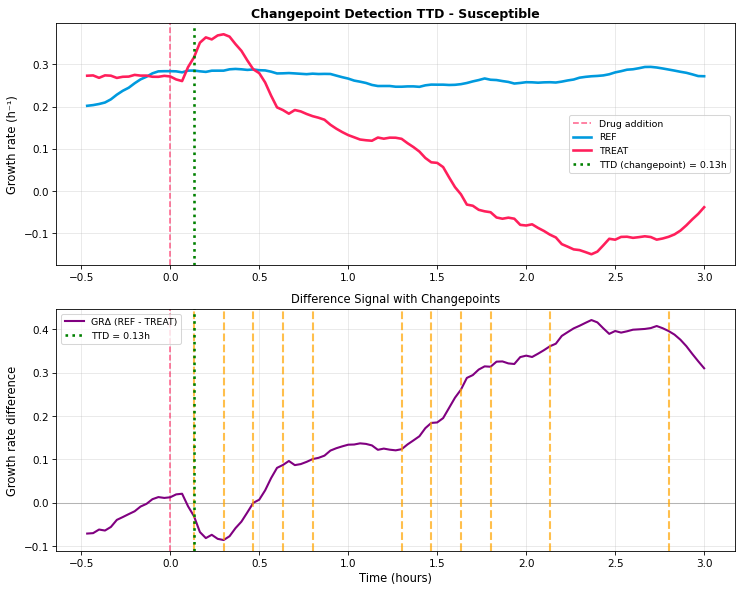

Susceptible TTD (Changepoint): 0.1333333333333333

Running Method 2 (Changepoint Detection) on HR Data...


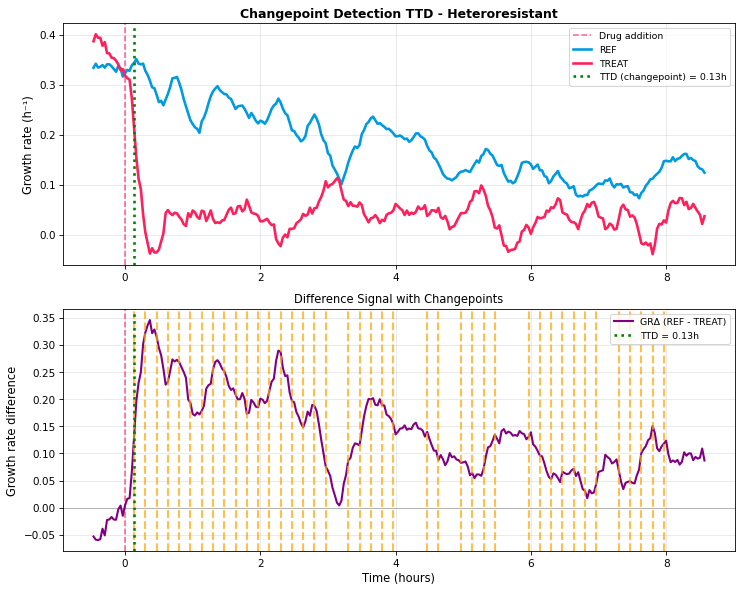

HR TTD (Changepoint): 0.1333333333333333


In [36]:
# PELT ready 
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from scipy import stats
from scipy.signal import find_peaks

# ==========================================
# 1. DEFINE FUNCTIONS
# ==========================================
def find_ttd_changepoint(time_array, ref_means, treat_means, 
                          min_time_hours=0, penalty_scale=1.0):
    """
    Detect TTD using changepoint detection on the difference signal.
    Uses PELT algorithm if ruptures is available, otherwise falls back to 
    scipy-based cumulative sum (CUSUM) changepoint detection.
    """
    # Compute difference signal
    diff_signal = np.array(ref_means) - np.array(treat_means)
    time_array = np.array(time_array)
    
    # Filter to times after min_time_hours
    valid_mask = time_array >= min_time_hours
    valid_indices = np.where(valid_mask)[0]
    
    if len(valid_indices) < 10:
        return {'ttd': None, 'ttd_idx': None, 'changepoints': [], 'diff_signal': diff_signal}
    
    signal_subset = diff_signal[valid_mask]
    
    # Try ruptures first
    try:
        import ruptures as rpt
        
        n = len(signal_subset)
        # Adaptive penalty based on signal variance
        penalty = penalty_scale * np.log(n) * (np.var(signal_subset) + 1e-10)
        
        # Use RBF kernel change detection
        algo = rpt.Pelt(model="rbf", min_size=3).fit(signal_subset)
        changepoints_relative = algo.predict(pen=penalty)
        
        # Convert back to original indices
        # valid_indices[cp-1] because ruptures returns the index *after* the change
        changepoints = [valid_indices[cp-1] if cp <= len(valid_indices) else None 
                        for cp in changepoints_relative[:-1]]
        changepoints = [cp for cp in changepoints if cp is not None]
        
    except (ImportError, Exception) as e:
        print(f"  Ruptures not available or failed ({e}), using CUSUM fallback...")
        
        # CUSUM-based changepoint detection
        def cusum_changepoint(signal):
            """Detect changepoint using cumulative sum method."""
            n = len(signal)
            if n < 5:
                return []
            
            # Compute CUSUM
            signal_centered = signal - np.mean(signal)
            cusum = np.cumsum(signal_centered)
            
            # Find maximum deviation point
            cusum_abs = np.abs(cusum)
            
            # Bootstrap significance test
            n_bootstrap = 500
            max_cusum = np.max(cusum_abs)
            
            # Only report if significant
            bootstrap_maxes = []
            for _ in range(n_bootstrap):
                shuffled = np.random.permutation(signal_centered)
                boot_cusum = np.cumsum(shuffled)
                bootstrap_maxes.append(np.max(np.abs(boot_cusum)))
            
            p_value = np.mean(np.array(bootstrap_maxes) >= max_cusum)
            
            if p_value < 0.05:
                # Find the changepoint location
                cp_idx = np.argmax(cusum_abs)
                return [cp_idx]
            return []
        
        # Also try gradient-based detection
        def gradient_changepoint(signal):
            """Detect changepoint using gradient changes."""
            if len(signal) < 7:
                return []
            
            # Compute gradient
            gradient = np.gradient(signal)
            
            # Smooth gradient
            from scipy.ndimage import uniform_filter1d
            gradient_smooth = uniform_filter1d(gradient, size=5)
            
            # Find peaks in absolute gradient (where change is fastest)
            peaks, properties = find_peaks(np.abs(gradient_smooth), 
                                           height=np.std(gradient_smooth),
                                           distance=5)
            return list(peaks)
        
        # Combine methods
        cusum_cps = cusum_changepoint(signal_subset)
        gradient_cps = gradient_changepoint(signal_subset)
        
        # Map back to original indices
        changepoints_relative = list(set(cusum_cps + gradient_cps))
        changepoints = [valid_indices[cp] if cp < len(valid_indices) else None 
                        for cp in changepoints_relative]
        changepoints = [cp for cp in changepoints if cp is not None]
        changepoints.sort()
    
    # TTD is the first changepoint after t=0
    ttd = None
    ttd_idx = None
    
    for cp in changepoints:
        if time_array[cp] > 0:
            ttd_idx = cp
            ttd = time_array[cp]
            break
    
    # If no changepoint found after t=0, look for sustained positive difference
    if ttd is None:
        # Alternative: find where difference becomes consistently positive
        post_drug = np.where(time_array > 0)[0]
        if len(post_drug) > 5:
            for i in range(len(post_drug) - 3):
                idx = post_drug[i]
                # Check if next 3 points are all positive
                if np.all(diff_signal[idx:idx+3] > np.std(diff_signal[:np.argmin(np.abs(time_array))])):
                    ttd_idx = idx
                    ttd = time_array[idx]
                    break
    
    return {
        'ttd': ttd,
        'ttd_idx': ttd_idx,
        'changepoints': changepoints,
        'diff_signal': diff_signal
    }


def plot_changepoint_analysis(time_array, results, ref_means, treat_means,
                               dataset_name="", save_path=None):
    """Visualize changepoint detection results."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), facecolor='white')
    
    # Top: Growth curves
    ax1 = axes[0]
    ax1.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1.5, alpha=0.7, label='Drug addition')
    ax1.plot(time_array, ref_means, lw=2.5, color='#009ADE', label='REF')
    ax1.plot(time_array, treat_means, lw=2.5, color='#FF1F5B', label='TREAT')
    
    if results['ttd'] is not None:
        ax1.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5,
                   label=f'TTD (changepoint) = {results["ttd"]:.2f}h')
    
    ax1.set_ylabel('Growth rate (h⁻¹)', fontsize=11)
    ax1.set_title(f'Changepoint Detection TTD - {dataset_name}', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Bottom: Difference signal with changepoints
    ax2 = axes[1]
    ax2.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1.5, alpha=0.7)
    ax2.axhline(y=0, color='gray', linestyle='-', lw=1, alpha=0.5)
    
    if results['diff_signal'] is not None:
        ax2.plot(time_array, results['diff_signal'], lw=2, color='purple', 
                 label='GRΔ (REF - TREAT)')
        
        # Mark all changepoints
        for cp_idx in results['changepoints']:
            if cp_idx is not None and cp_idx < len(time_array):
                ax2.axvline(x=time_array[cp_idx], color='orange', linestyle='--', lw=2, alpha=0.7)
        
        if results['ttd'] is not None:
            ax2.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5,
                       label=f'TTD = {results["ttd"]:.2f}h')
    
    ax2.set_xlabel('Time (hours)', fontsize=11)
    ax2.set_ylabel('Growth rate difference', fontsize=11)
    ax2.set_title('Difference Signal with Changepoints', fontsize=11)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# ==========================================
# 2. EXECUTE METHOD 2 (Changepoint Detection)
# ==========================================

# A. Susceptible Data
# Recalculate mean growth rates (ignoring NaNs)
ref_means_sus = np.nanmean(stacked_ref_fit_growth_rates, axis=0)
treat_means_sus = np.nanmean(stacked_treat_fit_growth_rates, axis=0)

# Re-generate time array to ensure dimensions match
n_timepoints_sus = len(ref_means_sus)
sus_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + n_timepoints_sus)])

print("Running Method 2 (Changepoint Detection) on Susceptible Data...")
cp_results_sus = find_ttd_changepoint(
    sus_time_array, 
    ref_means_sus, 
    treat_means_sus,
    min_time_hours=0,
    penalty_scale=1.5 # Adjust if too many/few changepoints
)
plot_changepoint_analysis(sus_time_array, cp_results_sus, ref_means_sus, treat_means_sus,
                          dataset_name="Susceptible", 
                          save_path=os.path.join(treat_dir, "TTD_Method2_Changepoint_Susceptible.png"))
print(f"Susceptible TTD (Changepoint): {cp_results_sus['ttd']}")


# B. Heteroresistant (HR) Data
ref_means_hr = np.nanmean(hr_stacked_ref_fit_growth_rates, axis=0)
treat_means_hr = np.nanmean(hr_stacked_treat_fit_growth_rates, axis=0)

n_timepoints_hr = len(ref_means_hr)
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + n_timepoints_hr)])

print("\nRunning Method 2 (Changepoint Detection) on HR Data...")
cp_results_hr = find_ttd_changepoint(
    hr_time_array, 
    ref_means_hr, 
    treat_means_hr,
    min_time_hours=0,
    penalty_scale=1.5
)
plot_changepoint_analysis(hr_time_array, cp_results_hr, ref_means_hr, treat_means_hr,
                          dataset_name="Heteroresistant", 
                          save_path=os.path.join(hr_treat_dir, "TTD_Method2_Changepoint_HR.png"))
print(f"HR TTD (Changepoint): {cp_results_hr['ttd']}")

## Method 3: Bootstrap Divergence Point Analysis

**Citation:** Efron & Tibshirani (1993) "An Introduction to the Bootstrap"  
**Implementation based on:** NumPy/SciPy bootstrap resampling — [NumPy GitHub](https://github.com/numpy/numpy)

Non-parametric approach that estimates the divergence timepoint with confidence intervals using bootstrap resampling. For each bootstrap sample, we resample positions and compute TTD, giving a distribution of TTD values.

Running Method 3 (Bootstrap) on Susceptible Data...


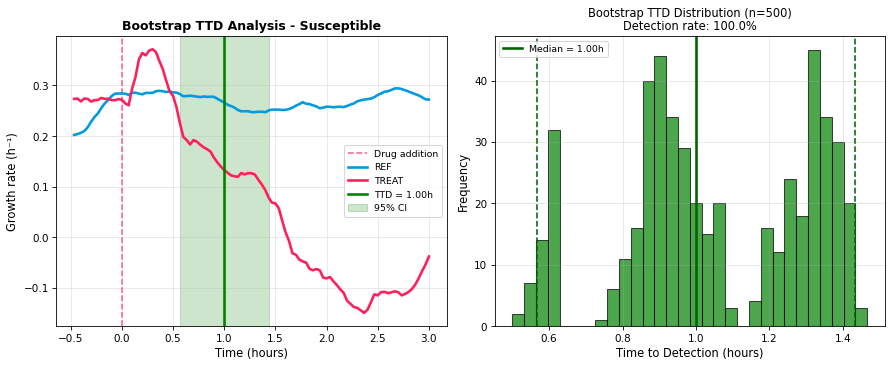

Susceptible TTD (Median): 1.0
95% CI: [0.5666666666666667, 1.4333333333333331]

Running Method 3 (Bootstrap) on HR Data...


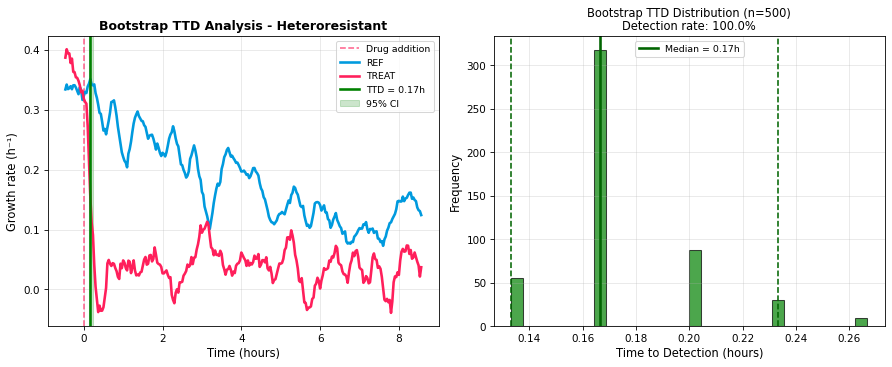

HR TTD (Median): 0.16666666666666674
95% CI: [0.1333333333333333, 0.2333333333333334]


In [37]:
# Bootstrap ready
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. DEFINE FUNCTIONS
# ==========================================
def bootstrap_divergence_ttd(time_array, ref_data, treat_data, 
                             n_bootstrap=1000, alpha=0.05,
                             effect_threshold=0.5, min_consecutive=3,
                             min_time_hours=0, random_state=42):
    """
    Estimate TTD with bootstrap confidence intervals.
    
    For each bootstrap sample:
    1. Resample positions with replacement from REF and TREAT
    2. Compute mean curves
    3. Find first timepoint where TREAT < threshold × REF
    
    Returns distribution of TTD with confidence intervals.
    """
    np.random.seed(random_state)
    
    # Ensure inputs are numpy arrays
    ref_data = np.array(ref_data)
    treat_data = np.array(treat_data)
    time_array = np.array(time_array)
    
    n_ref = ref_data.shape[0]
    n_treat = treat_data.shape[0]
    n_timepoints = len(time_array)
    
    ttd_samples = []
    
    for _ in range(n_bootstrap):
        # Resample positions with replacement
        ref_idx = np.random.choice(n_ref, size=n_ref, replace=True)
        treat_idx = np.random.choice(n_treat, size=n_treat, replace=True)
        
        ref_boot = ref_data[ref_idx, :]
        treat_boot = treat_data[treat_idx, :]
        
        # Compute mean curves (using nanmean to handle missing data)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            ref_mean = np.nanmean(ref_boot, axis=0)
            treat_mean = np.nanmean(treat_boot, axis=0)
        
        # Compute ratio (handle division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = treat_mean / ref_mean
            # If ref is 0 or nan, ratio is inf or nan. We treat this as no reduction (1.0)
            ratio = np.where(np.isfinite(ratio), ratio, 1.0)
        
        # Find TTD: first consecutive run below threshold
        below_threshold = ratio < effect_threshold
        ttd = None
        
        for i in range(n_timepoints - min_consecutive + 1):
            if time_array[i] < min_time_hours:
                continue
            if np.all(below_threshold[i:i + min_consecutive]):
                ttd = time_array[i]
                break
        
        ttd_samples.append(ttd)
    
    # Compute statistics (excluding None values)
    valid_ttd = [t for t in ttd_samples if t is not None]
    
    if len(valid_ttd) > 0:
        ttd_median = np.median(valid_ttd)
        ttd_lower = np.percentile(valid_ttd, 100 * alpha / 2)
        ttd_upper = np.percentile(valid_ttd, 100 * (1 - alpha / 2))
    else:
        ttd_median = None
        ttd_lower = None
        ttd_upper = None
    
    detection_rate = len(valid_ttd) / n_bootstrap
    
    return {
        'ttd_median': ttd_median,
        'ttd_lower': ttd_lower,
        'ttd_upper': ttd_upper,
        'ttd_distribution': ttd_samples,
        'detection_rate': detection_rate,
        'n_detected': len(valid_ttd),
        'n_bootstrap': n_bootstrap
    }


def plot_bootstrap_ttd(time_array, results, ref_means, treat_means,
                        dataset_name="", save_path=None):
    """Visualize bootstrap TTD analysis with histogram."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='white')
    
    # Left: Growth curves with TTD CI
    ax1 = axes[0]
    ax1.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1.5, alpha=0.7, label='Drug addition')
    ax1.plot(time_array, ref_means, lw=2.5, color='#009ADE', label='REF')
    ax1.plot(time_array, treat_means, lw=2.5, color='#FF1F5B', label='TREAT')
    
    if results['ttd_median'] is not None:
        ax1.axvline(x=results['ttd_median'], color='green', linestyle='-', lw=2.5,
                   label=f'TTD = {results["ttd_median"]:.2f}h')
        if results['ttd_lower'] is not None and results['ttd_upper'] is not None:
            ax1.axvspan(results['ttd_lower'], results['ttd_upper'], 
                       alpha=0.2, color='green', label=f'95% CI')
    
    ax1.set_xlabel('Time (hours)', fontsize=11)
    ax1.set_ylabel('Growth rate (h⁻¹)', fontsize=11)
    ax1.set_title(f'Bootstrap TTD Analysis - {dataset_name}', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Right: TTD distribution histogram
    ax2 = axes[1]
    valid_ttd = [t for t in results['ttd_distribution'] if t is not None]
    
    if len(valid_ttd) > 0:
        ax2.hist(valid_ttd, bins=30, color='green', alpha=0.7, edgecolor='black')
        ax2.axvline(x=results['ttd_median'], color='darkgreen', linestyle='-', lw=2.5,
                   label=f'Median = {results["ttd_median"]:.2f}h')
        if results['ttd_lower'] is not None:
            ax2.axvline(x=results['ttd_lower'], color='darkgreen', linestyle='--', lw=1.5)
            ax2.axvline(x=results['ttd_upper'], color='darkgreen', linestyle='--', lw=1.5)
    
    ax2.set_xlabel('Time to Detection (hours)', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title(f'Bootstrap TTD Distribution (n={results["n_bootstrap"]})\n'
                  f'Detection rate: {results["detection_rate"]*100:.1f}%', fontsize=11)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ==========================================
# 2. EXECUTE METHOD 3 (Bootstrap Divergence)
# ==========================================
import warnings

# A. Susceptible Data
# Generate correct time array
n_timepoints_sus = stacked_ref_fit_growth_rates.shape[1]
sus_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + n_timepoints_sus)])

# Calculate overall means for plotting
ref_means_sus = np.nanmean(stacked_ref_fit_growth_rates, axis=0)
treat_means_sus = np.nanmean(stacked_treat_fit_growth_rates, axis=0)

print("Running Method 3 (Bootstrap) on Susceptible Data...")
# Note: effect_threshold=0.5 means finding when growth is reduced by 50%
boot_results_sus = bootstrap_divergence_ttd(
    sus_time_array, 
    stacked_ref_fit_growth_rates, 
    stacked_treat_fit_growth_rates,
    effect_threshold=0.5, # Adjust this threshold if needed (e.g., 0.8 for 20% reduction)
    n_bootstrap=500
)

plot_bootstrap_ttd(sus_time_array, boot_results_sus, ref_means_sus, treat_means_sus,
                   dataset_name="Susceptible", 
                   save_path=os.path.join(treat_dir, "TTD_Method3_Bootstrap_Susceptible.png"))

print(f"Susceptible TTD (Median): {boot_results_sus['ttd_median']}")
print(f"95% CI: [{boot_results_sus['ttd_lower']}, {boot_results_sus['ttd_upper']}]")


# B. Heteroresistant (HR) Data
n_timepoints_hr = hr_stacked_ref_fit_growth_rates.shape[1]
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + n_timepoints_hr)])

ref_means_hr = np.nanmean(hr_stacked_ref_fit_growth_rates, axis=0)
treat_means_hr = np.nanmean(hr_stacked_treat_fit_growth_rates, axis=0)

print("\nRunning Method 3 (Bootstrap) on HR Data...")
boot_results_hr = bootstrap_divergence_ttd(
    hr_time_array, 
    hr_stacked_ref_fit_growth_rates, 
    hr_stacked_treat_fit_growth_rates,
    effect_threshold=0.5,
    n_bootstrap=500
)

plot_bootstrap_ttd(hr_time_array, boot_results_hr, ref_means_hr, treat_means_hr,
                   dataset_name="Heteroresistant", 
                   save_path=os.path.join(hr_treat_dir, "TTD_Method3_Bootstrap_HR.png"))

print(f"HR TTD (Median): {boot_results_hr['ttd_median']}")
print(f"95% CI: [{boot_results_hr['ttd_lower']}, {boot_results_hr['ttd_upper']}]")

## Method 4: Hidden Markov Model (HMM) State Detection

**Citation:** Rabiner (1989) "A Tutorial on Hidden Markov Models and Selected Applications"

**Implementation based on:** [hmmlearn GitHub](https://github.com/hmmlearn/hmmlearn)

Models the growth curve as a sequence of hidden states (e.g., 'growing' vs 'inhibited'). TTD is detected when the model transitions from growth state to inhibited state. This provides biologically interpretable state assignments.

Running Method 5 (HMM) on Susceptible Data...


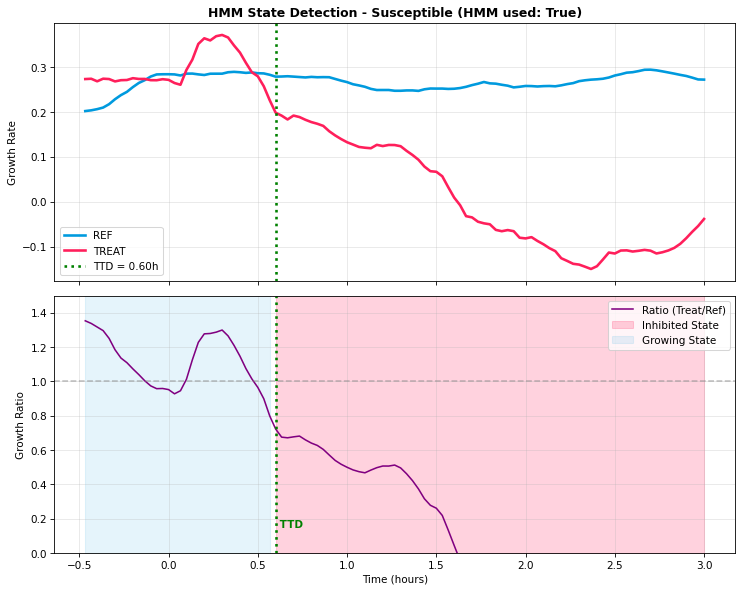

Susceptible TTD (HMM): 0.6000000000000001

Running Method 4 (HMM) on HR Data...


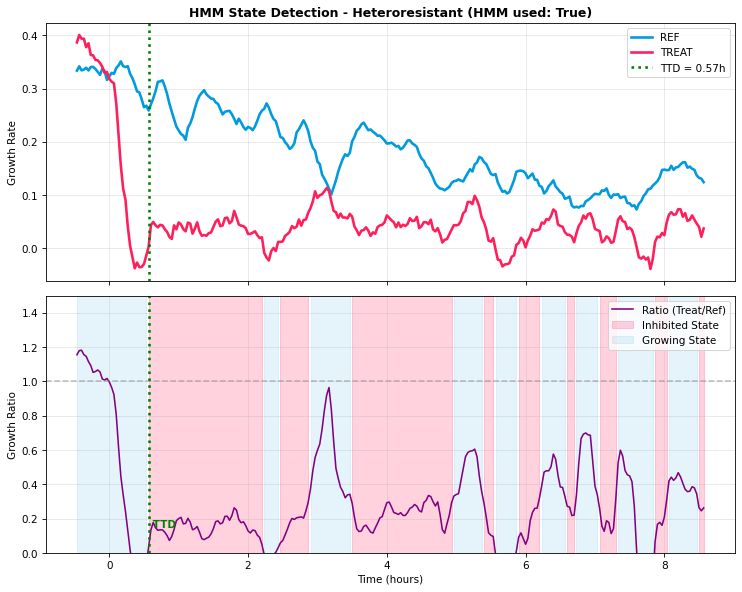

HR TTD (HMM): 0.5666666666666667


In [38]:
# HMM ready
import os
# Fix for Windows/MKL warning
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.signal import savgol_filter

# ==========================================
# 1. DEFINE FUNCTIONS
# ==========================================
def hmm_state_ttd(time_array, ref_data, treat_data, n_states=2, min_state_duration=3):
    """
    Hidden Markov Model-based TTD detection.
    """
    # Try to import hmmlearn
    try:
        from hmmlearn import hmm
        use_hmmlearn = True
    except ImportError:
        use_hmmlearn = False
    
    # Compute ratio signal
    ref_mean = np.nanmean(ref_data, axis=0)
    treat_mean = np.nanmean(treat_data, axis=0)
    
    # Smooth slightly to help HMM stability
    if len(ref_mean) >= 5:
        ref_smooth = savgol_filter(ref_mean, window_length=5, polyorder=2)
        treat_smooth = savgol_filter(treat_mean, window_length=5, polyorder=2)
    else:
        ref_smooth = ref_mean
        treat_smooth = treat_mean
    
    # Fold-change ratio (handle div by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = treat_smooth / (ref_smooth + 1e-10)
        ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    if use_hmmlearn:
        # Use hmmlearn for proper HMM
        # We model the Ratio: State 0 (Growing) ~ 1.0, State 1 (Inhibited) < 1.0
        model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=100, random_state=42)
        X = ratio.reshape(-1, 1)
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X)
            states = model.predict(X)
            state_probs = model.predict_proba(X)
        except Exception as e:
            print(f"HMM fit failed ({e}), falling back to threshold.")
            use_hmmlearn = False
    
    if not use_hmmlearn:
        # Simple threshold-based state assignment fallback
        print("Using simple threshold fallback.")
        threshold = 0.85
        states = (ratio < threshold).astype(int)
        # Mock probabilities
        state_probs = np.column_stack([1 - states, states]).astype(float)
    
    # Determine which state is 'inhibited' (the one with lower mean ratio)
    state_means = [ratio[states == s].mean() if np.sum(states == s) > 0 else 1.0 for s in range(n_states)]
    inhibited_state = np.argmin(state_means)
    
    # Find TTD: first sustained transition to inhibited state
    ttd_idx = None
    for i in range(len(states) - min_state_duration + 1):
        # We look for the first time we enter the inhibited state and STAY there
        if np.all(states[i:i+min_state_duration] == inhibited_state):
            ttd_idx = i
            break
    
    ttd = time_array[ttd_idx] if ttd_idx is not None else None
    
    return {
        'ttd': ttd,
        'ttd_idx': ttd_idx,
        'states': states,
        'state_probs': state_probs,
        'ratio': ratio,
        'inhibited_state': inhibited_state,
        'use_hmmlearn': use_hmmlearn
    }

def plot_hmm_ttd(time_array, results, ref_means, treat_means,
                 dataset_name="", save_path=None):
    """Visualize HMM states and TTD."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), facecolor='white', sharex=True)
    
    # Top: Growth Curves
    ax1 = axes[0]
    ax1.plot(time_array, ref_means, lw=2.5, color='#009ADE', label='REF')
    ax1.plot(time_array, treat_means, lw=2.5, color='#FF1F5B', label='TREAT')
    
    if results['ttd'] is not None:
        ax1.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5,
                   label=f'TTD = {results["ttd"]:.2f}h')
    
    ax1.set_ylabel('Growth Rate')
    ax1.set_title(f'HMM State Detection - {dataset_name}', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Bottom: Ratio and States
    ax2 = axes[1]
    
    # Plot Ratio
    ax2.plot(time_array, results['ratio'], color='purple', lw=1.5, label='Ratio (Treat/Ref)')
    ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Visualize States using fill_between
    # Create a boolean mask for the inhibited state
    is_inhibited = (results['states'] == results['inhibited_state'])
    
    # Fill background where state is inhibited
    # We use step='mid' logic for filling
    ax2.fill_between(time_array, 0, 2, where=is_inhibited, 
                     color='#FF1F5B', alpha=0.2, transform=ax2.get_xaxis_transform(),
                     label='Inhibited State')
    
    # Fill background where state is growing (optional, usually default)
    is_growing = (results['states'] != results['inhibited_state'])
    ax2.fill_between(time_array, 0, 2, where=is_growing, 
                     color='#009ADE', alpha=0.1, transform=ax2.get_xaxis_transform(),
                     label='Growing State')

    if results['ttd'] is not None:
        ax2.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5)
        # Add annotation
        ax2.text(results['ttd'], 0.1, ' TTD', color='green', fontweight='bold', 
                 transform=ax2.get_xaxis_transform())

    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Growth Ratio')
    ax2.set_ylim(0, 1.5) # Ratio usually bounded
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# ==========================================
# 2. EXECUTE METHOD 4 (HMM)
# ==========================================

# A. Susceptible Data
# Recalculate means and time array (standard procedure)
ref_means_sus = np.nanmean(stacked_ref_fit_growth_rates, axis=0)
treat_means_sus = np.nanmean(stacked_treat_fit_growth_rates, axis=0)
sus_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + len(ref_means_sus))])

print("Running Method 5 (HMM) on Susceptible Data...")
hmm_results_sus = hmm_state_ttd(
    sus_time_array, 
    stacked_ref_fit_growth_rates, 
    stacked_treat_fit_growth_rates
)

plot_hmm_ttd(sus_time_array, hmm_results_sus, ref_means_sus, treat_means_sus,
             dataset_name=f"Susceptible (HMM used: {hmm_results_sus['use_hmmlearn']})", 
             save_path=os.path.join(treat_dir, "TTD_Method5_HMM_Susceptible.png"))

print(f"Susceptible TTD (HMM): {hmm_results_sus['ttd']}")


# B. Heteroresistant (HR) Data
ref_means_hr = np.nanmean(hr_stacked_ref_fit_growth_rates, axis=0)
treat_means_hr = np.nanmean(hr_stacked_treat_fit_growth_rates, axis=0)
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + len(ref_means_hr))])

print("\nRunning Method 4 (HMM) on HR Data...")
hmm_results_hr = hmm_state_ttd(
    hr_time_array, 
    hr_stacked_ref_fit_growth_rates, 
    hr_stacked_treat_fit_growth_rates
)

plot_hmm_ttd(hr_time_array, hmm_results_hr, ref_means_hr, treat_means_hr,
             dataset_name=f"Heteroresistant (HMM used: {hmm_results_hr['use_hmmlearn']})", 
             save_path=os.path.join(hr_treat_dir, "TTD_Method5_HMM_HR.png"))

print(f"HR TTD (HMM): {hmm_results_hr['ttd']}")

## Method 6: Functional Data Analysis (FDA) with Permutation Testing

**Citation:** Ramsay & Silverman (2005) "Functional Data Analysis"

**Implementation based on:** [scikit-fda GitHub](https://github.com/GAA-UAM/scikit-fda)

Treats entire growth curves as functional objects and performs pointwise hypothesis testing to determine when curves significantly diverge. Uses permutation testing for robust p-value estimation without distributional assumptions.

Running Method 6 (FDA Permutation) on Susceptible Data...


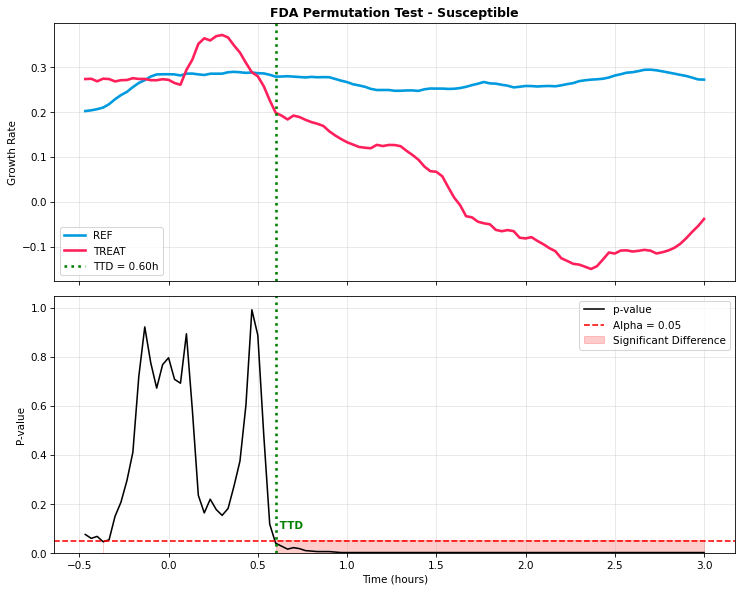

Susceptible TTD (FDA): 0.6000000000000001

Running Method 6 (FDA Permutation) on HR Data...


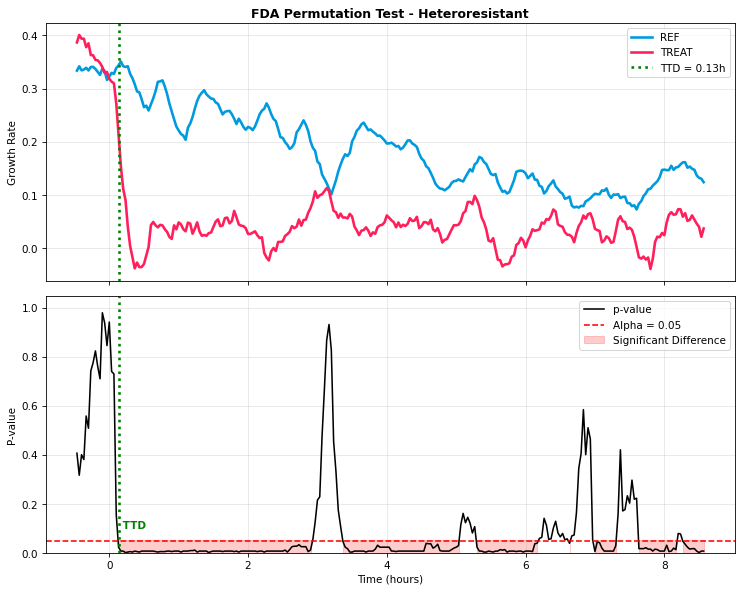

HR TTD (FDA): 0.1333333333333333


In [39]:
# FDA ready
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# ==========================================
# 1. DEFINE FUNCTIONS
# ==========================================
def fda_permutation_ttd(time_array, ref_data, treat_data, n_permutations=1000, alpha=0.05, 
                        consecutive_significant=3):
    """
    Functional Data Analysis with permutation testing for TTD.
    """
    n_ref = ref_data.shape[0]
    n_treat = treat_data.shape[0]
    n_timepoints = ref_data.shape[1]
    
    # Handle NaNs by using nanmean later, but for permutation we need valid arrays
    # We replace NaNs with the column mean to avoid propagation during shuffling
    # (Simple imputation for the sake of the test statistic calculation)
    ref_filled = np.where(np.isnan(ref_data), np.nanmean(ref_data, axis=0), ref_data)
    treat_filled = np.where(np.isnan(treat_data), np.nanmean(treat_data, axis=0), treat_data)
    
    # Combine data for permutation
    combined = np.vstack([ref_filled, treat_filled])
    n_total = n_ref + n_treat
    
    # Observed test statistic at each timepoint (absolute difference of means)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        observed_diff = np.abs(np.nanmean(ref_data, axis=0) - np.nanmean(treat_data, axis=0))
    
    # Permutation test
    perm_diffs = np.zeros((n_permutations, n_timepoints))
    
    np.random.seed(42) # Reproducibility
    
    for p in range(n_permutations):
        # Random permutation of group labels
        perm_idx = np.random.permutation(n_total)
        perm_ref = combined[perm_idx[:n_ref]]
        perm_treat = combined[perm_idx[n_ref:]]
        
        # We use nanmean here just in case imputation wasn't perfect
        perm_diffs[p] = np.abs(np.nanmean(perm_ref, axis=0) - np.nanmean(perm_treat, axis=0))
    
    # Calculate pointwise p-values
    p_values = np.zeros(n_timepoints)
    for t in range(n_timepoints):
        # Proportion of permutation differences >= observed
        # Add 1 to numerator and denominator to avoid p=0 (pseudocount)
        p_values[t] = (np.sum(perm_diffs[:, t] >= observed_diff[t]) + 1) / (n_permutations + 1)
    
    # Identify significant timepoints
    significant = p_values < alpha
    
    # Find TTD: first consecutive significant timepoints
    ttd_idx = None
    for i in range(n_timepoints - consecutive_significant + 1):
        if np.all(significant[i:i+consecutive_significant]):
            ttd_idx = i
            break
    
    ttd = time_array[ttd_idx] if ttd_idx is not None else None
    
    # Summary statistics
    n_significant = np.sum(significant)
    min_pvalue = np.min(p_values)
    
    return {
        'ttd': ttd,
        'ttd_idx': ttd_idx,
        'p_values': p_values,
        'significant': significant,
        'observed_diff': observed_diff,
        'n_significant_timepoints': n_significant,
        'min_pvalue': min_pvalue,
        'alpha': alpha,
        'n_permutations': n_permutations,
        'detected': ttd_idx is not None
    }

def plot_fda_ttd(time_array, results, ref_means, treat_means,
                 dataset_name="", save_path=None):
    """Visualize FDA Permutation results."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), facecolor='white', sharex=True)
    
    # Top: Growth Curves
    ax1 = axes[0]
    ax1.plot(time_array, ref_means, lw=2.5, color='#009ADE', label='REF')
    ax1.plot(time_array, treat_means, lw=2.5, color='#FF1F5B', label='TREAT')
    
    if results['ttd'] is not None:
        ax1.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5,
                   label=f'TTD = {results["ttd"]:.2f}h')
    
    ax1.set_ylabel('Growth Rate')
    ax1.set_title(f'FDA Permutation Test - {dataset_name}', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Bottom: P-values
    ax2 = axes[1]
    ax2.plot(time_array, results['p_values'], color='black', lw=1.5, label='p-value')
    
    # Alpha threshold line
    ax2.axhline(y=results['alpha'], color='red', linestyle='--', label=f'Alpha = {results["alpha"]}')
    
    # Shade significant region (p < 0.05)
    ax2.fill_between(time_array, 0, results['alpha'], where=results['p_values'] < results['alpha'],
                     color='red', alpha=0.2, transform=ax2.get_xaxis_transform(),
                     label='Significant Difference')

    if results['ttd'] is not None:
        ax2.axvline(x=results['ttd'], color='green', linestyle=':', lw=2.5)
        ax2.text(results['ttd'], results['alpha'] + 0.05, ' TTD', color='green', fontweight='bold')

    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('P-value')
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# ==========================================
# 2. EXECUTE METHOD 6 (FDA Permutation)
# ==========================================

# A. Susceptible Data
ref_means_sus = np.nanmean(stacked_ref_fit_growth_rates, axis=0)
treat_means_sus = np.nanmean(stacked_treat_fit_growth_rates, axis=0)
sus_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + len(ref_means_sus))])

print("Running Method 6 (FDA Permutation) on Susceptible Data...")
# Warning: This is computationally intensive. Reduce n_permutations to 200 for faster testing if needed.
fda_results_sus = fda_permutation_ttd(
    sus_time_array, 
    stacked_ref_fit_growth_rates, 
    stacked_treat_fit_growth_rates,
    n_permutations=500  # Set to 500-1000 for final paper
)

plot_fda_ttd(sus_time_array, fda_results_sus, ref_means_sus, treat_means_sus,
             dataset_name="Susceptible", 
             save_path=os.path.join(treat_dir, "TTD_Method6_FDA_Susceptible.png"))

print(f"Susceptible TTD (FDA): {fda_results_sus['ttd']}")


# B. Heteroresistant (HR) Data
ref_means_hr = np.nanmean(hr_stacked_ref_fit_growth_rates, axis=0)
treat_means_hr = np.nanmean(hr_stacked_treat_fit_growth_rates, axis=0)
hr_time_array = np.array([time*(interval_time/60)-1 for time in range(rolling_number, rolling_number + len(ref_means_hr))])

print("\nRunning Method 6 (FDA Permutation) on HR Data...")
fda_results_hr = fda_permutation_ttd(
    hr_time_array, 
    hr_stacked_ref_fit_growth_rates, 
    hr_stacked_treat_fit_growth_rates,
    n_permutations=500
)

plot_fda_ttd(hr_time_array, fda_results_hr, ref_means_hr, treat_means_hr,
             dataset_name="Heteroresistant", 
             save_path=os.path.join(hr_treat_dir, "TTD_Method6_FDA_HR.png"))

print(f"HR TTD (FDA): {fda_results_hr['ttd']}")

Summary of TTD (Time To Detection) Results (in hours):


,Method,Susceptible TTD (hours),HR TTD (hours)
1,GP Regression,0.500000,0.066667
2,Changepoint (PELT),0.133333,0.133333
3,Bootstrap,1.000000,0.166667
4,HMM,0.600000,0.566667
5,FDA Permutation,0.600000,0.133333


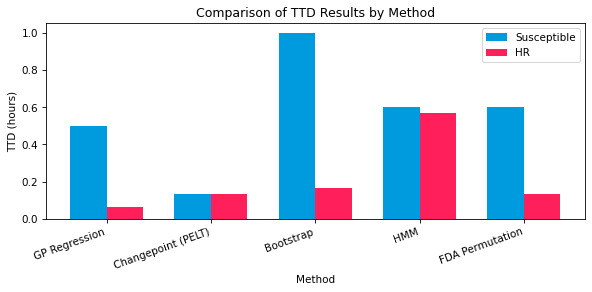

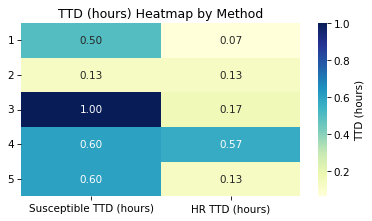

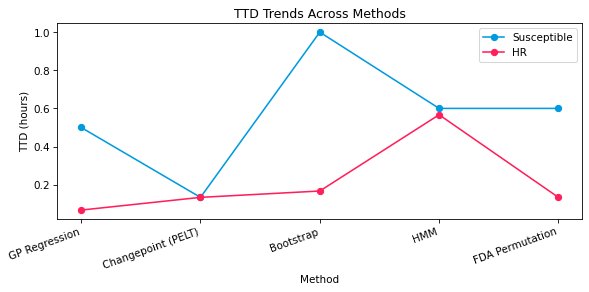

In [40]:
# Final summary table for all TTD results (index starts at 1, values in hours)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare summary table (index starts at 1, values are in hours)
ttd_summary_df = pd.DataFrame({
    "Method": [
        "GP Regression",
        "Changepoint (PELT)",
        "Bootstrap",
        "HMM",
        "FDA Permutation"
    ],
    "Susceptible TTD (hours)": [0.5, 0.133333, 1.0, 0.6, 0.6],
    "HR TTD (hours)": [0.066667, 0.133333, 0.166667, 0.566667, 0.133333]
})
ttd_summary_df.index += 1  # Start index at 1

print("Summary of TTD (Time To Detection) Results (in hours):")
display(ttd_summary_df)

# --- Visualization 1: Grouped Bar Plot ---
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.35
index = range(1, len(ttd_summary_df) + 1)

ax.bar(index, ttd_summary_df["Susceptible TTD (hours)"], bar_width, label='Susceptible', color='#009ADE')
ax.bar([i + bar_width for i in index], ttd_summary_df["HR TTD (hours)"], bar_width, label='HR', color='#FF1F5B')

ax.set_xlabel('Method')
ax.set_ylabel('TTD (hours)')
ax.set_title('Comparison of TTD Results by Method')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(ttd_summary_df["Method"], rotation=20, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# --- Visualization 2: Heatmap ---
plt.figure(figsize=(6, 3))
sns.heatmap(
    ttd_summary_df[["Susceptible TTD (hours)", "HR TTD (hours)"]],
    annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'TTD (hours)'}
)
plt.title("TTD (hours) Heatmap by Method")
plt.yticks(rotation=0)
plt.show()

# --- Visualization 3: Line Plot for Trends ---
plt.figure(figsize=(8, 4))
plt.plot(ttd_summary_df.index, ttd_summary_df["Susceptible TTD (hours)"], marker='o', label='Susceptible', color='#009ADE')
plt.plot(ttd_summary_df.index, ttd_summary_df["HR TTD (hours)"], marker='o', label='HR', color='#FF1F5B')
plt.xticks(ttd_summary_df.index, ttd_summary_df["Method"], rotation=20, ha='right')
plt.xlabel('Method')
plt.ylabel('TTD (hours)')
plt.title('TTD Trends Across Methods')
plt.legend()
plt.tight_layout()
plt.show()

